In [1]:
!pip install pandas
!pip install scikit-learn


[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [42]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from sklearn.preprocessing import MinMaxScaler


#data1 = pd.read_csv('FontSelectionSpectrum.csv')
data = pd.read_csv('FontSelectionSpectrumFFT2.csv')
data_subgrps = pd.read_csv('FontSpectraWithBezierSubGrps.csv')

NB_COEFF = 250


# Useful functions

# Parse the text value representing a complex number
def parse_complex(s):
    s = s.strip()
    try:
        real_part, imaginary_part = s.split(' + ')
        real = float(real_part)
        imaginary = float(imaginary_part)
        return complex(real, imaginary)
    except ValueError:
        return np.nan

# return the characaters that are common to all the fonts in both given groups
def common_chars(data_grp1, data_grp2):
    grp1_characters_by_font = data_grp1.groupby('Font')['Character'].unique()
    grp2_characters_by_font = data_grp2.groupby('Font')['Character'].unique()
    common_grp1_characters = set.intersection(*[set(chars) for chars in grp1_characters_by_font])
    common_grp2_characters = set.intersection(*[set(chars) for chars in grp2_characters_by_font])
    
    return common_grp1_characters.intersection(common_grp2_characters)


# Plot the amplitudes in the given spectrum
def plot_freq_amplitudes(spectrum, title, x_coords=None, y_limit=None):
    if x_coords == None:
        x_coords = [i - NB_COEFF / 2 for i in range(int(NB_COEFF / 2) * 2 + 1)]
        spectrum = np.insert(spectrum, int(NB_COEFF / 2), 0)
    y_coords = np.abs(spectrum)
    fig, ax = plt.subplots(figsize=(20, 10))
    if y_limit != None:
        ax.set_ylim([0, y_limit])
    plt.stem(x_coords, y_coords)
    plt.xticks(range(int(-len(x_coords) / 2 - 1), int(len(x_coords) / 2), 20))
    plt.title(title)
    plt.xlabel('frequency K')
    plt.ylabel('Amplitude')
    plt.show()


# Apply complex parsing to all values in the given spectrum dataframe
def apply_parse_complex(spectrum):
    return pd.concat([spectrum[column].map(parse_complex) for column in spectrum.columns], axis=1)
    
# Apply absolute value (to get the amplitude of the coefficient), to all values in the given spectrum dataframe
def apply_abs(spectrum):
    return pd.concat([spectrum[column].map(np.abs) for column in spectrum.columns], axis=1)


# Apply min_max scaling to the data
# Make sure the normalizatin is consistent between test and train sets by applying the same transformation to both
def apply_min_max(train_data, test_data=None):
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    
    train_scaled = scaler.transform(train_data)
    train_scaled_df = pd.DataFrame(train_scaled, columns=train_data.columns, index=train_data.index)
    
    if test_data is not None:
        test_scaled = scaler.transform(test_data)
        test_scaled_df = pd.DataFrame(test_scaled, columns=test_data.columns, index=test_data.index)
    else:
        test_scaled_df = None
    
    return train_scaled_df, test_scaled_df
    

# Return a dataFrame containg only the rows for the given groups. If commonc-chars_only is True, return only the common
# characters within the groups
def combine_groups(grp1, grp2, source_data, common_chars_only=True):
    # Filter data to keep only the common characters and specified groups
    combined = source_data[(source_data[grp1] == True) | (source_data[grp2] == True)]

    if common_chars_only:
        common_characters = common_chars(source_data[source_data[grp1] == True], source_data[source_data[grp2] == True])
        combined = combined[combined['Character'].isin(common_characters)]
    
    return combined

# Extract the actual spectrum for the dataframe and process to get the amplitudes only
def spectrum_amplitudes(spectrum_all_columns):
    spectrum = spectrum_all_columns.loc[:, '-125':]
    spectrum = apply_parse_complex(spectrum)
    return apply_abs(spectrum)

# Data Exploration

Let's explore the data and test out some hypotheses about it.

First hypothesis: Serif letters should have larger amplitudes on average in the higher frequencies.

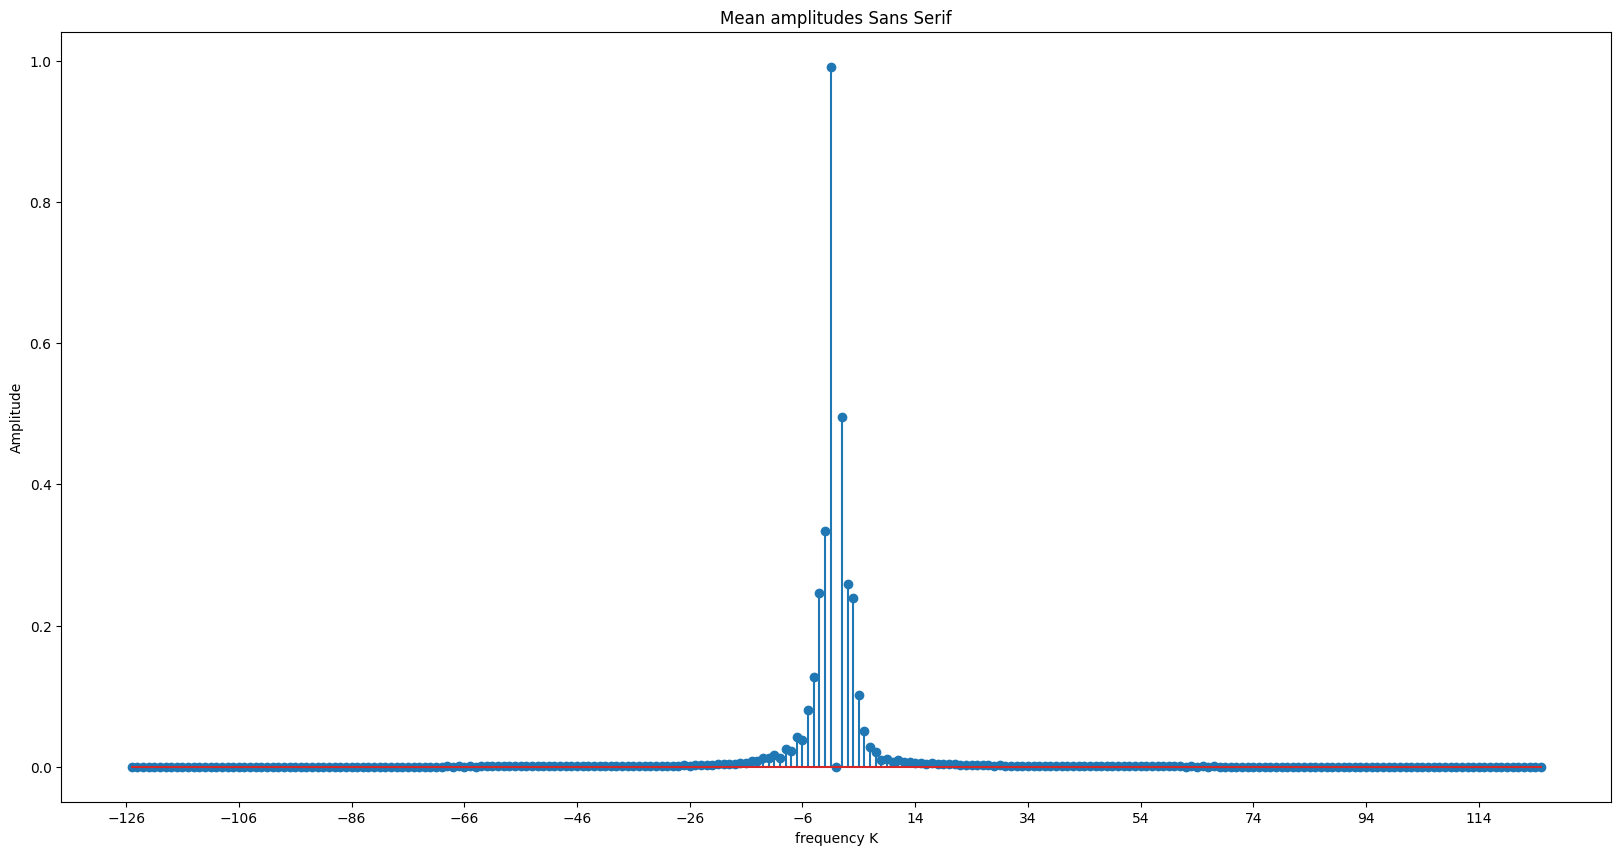

Does the frequency -1 have the biggest amplitude in every single instance?  False
How often does it?
631 out of 678 : 93.06784660766961%


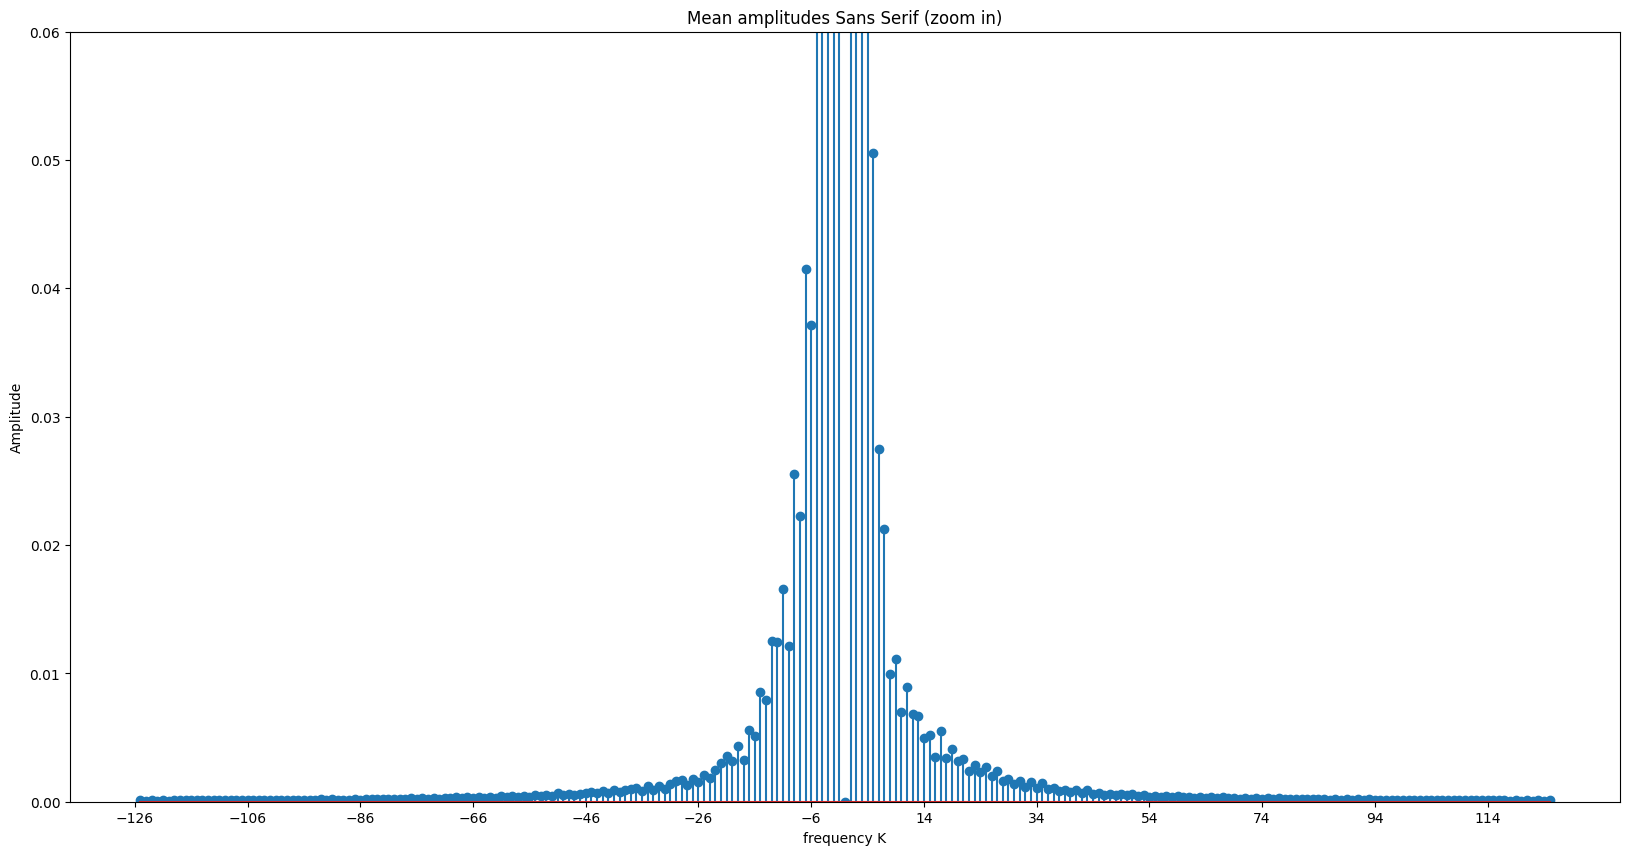

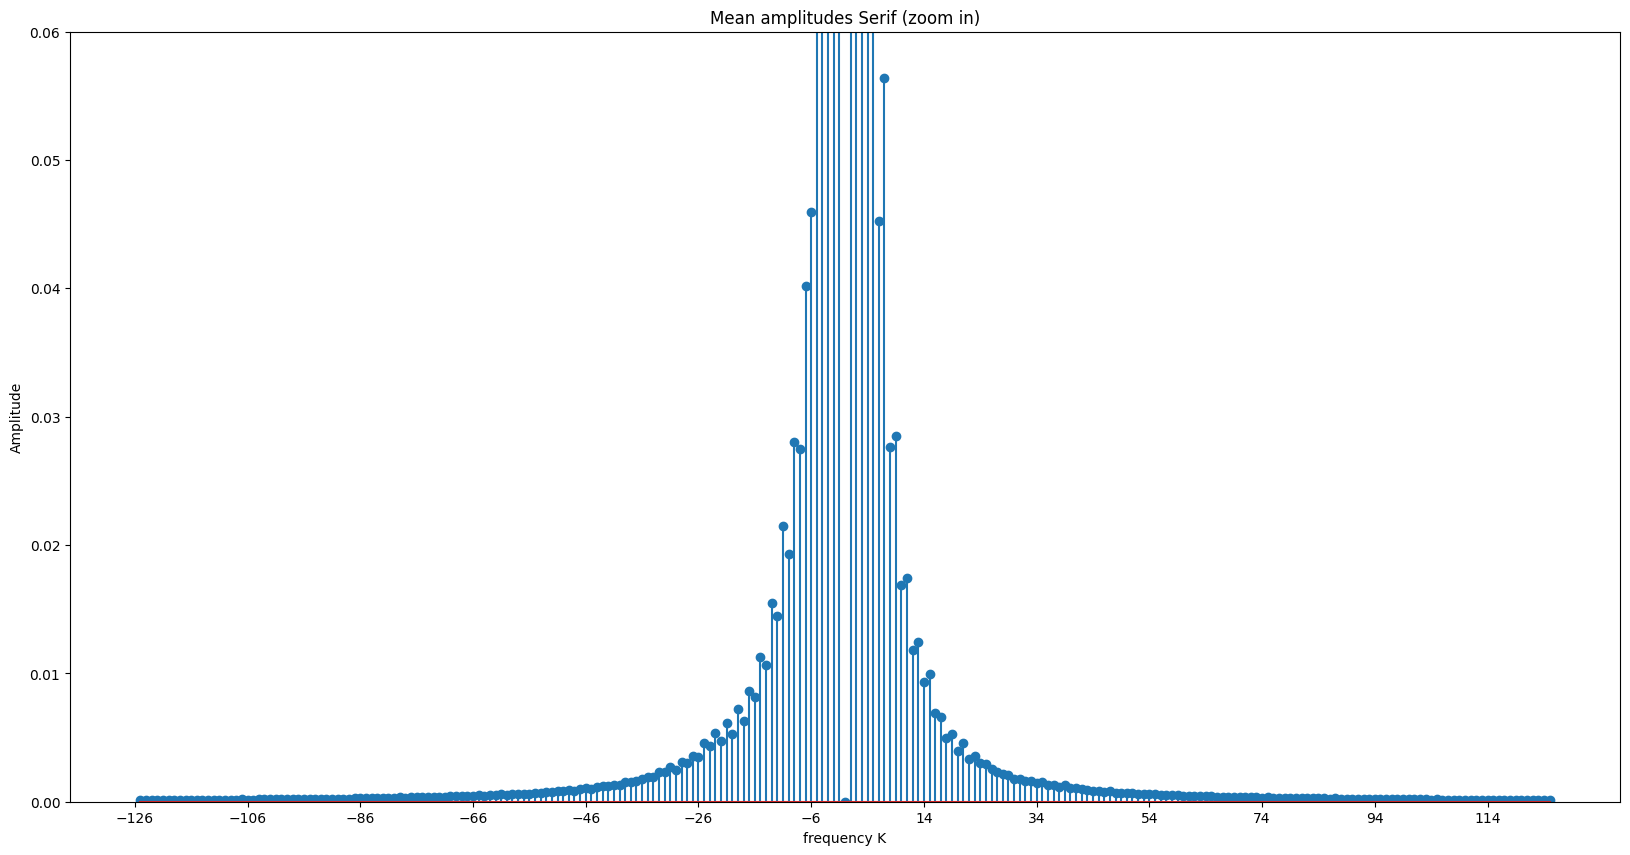

In [3]:
# Explore hypotheses

serif_data = data[data['Serif'] == True]
sans_data = data[data['SansSerif'] == True]


# The first 9 columns don't contain the spectrum data
sans_spectrum = spectrum_amplitudes(sans_data)
sans_mean = sans_spectrum.mean()

serif_spectrum = spectrum_amplitudes(serif_data)
serif_mean = serif_spectrum.mean()
plot_freq_amplitudes(sans_mean, 'Mean amplitudes Sans Serif')

# The frenquency -1 has a mean of 1 (almost). This is because of the direction the outline is being drawn is always the same.
# Select rows where the amplitude for frquency -1 is equal to 1
freq_minus1_equal_to_1 = serif_spectrum[serif_spectrum.iloc[:, 124] > 0.99]
percentage = len(freq_minus1_equal_to_1) / len(serif_spectrum.iloc[:, 124])
print('Does the frequency -1 have the biggest amplitude in every single instance?  ' + str((serif_spectrum.iloc[:, 124]== 1.0).all()))
print(f'How often does it?\n{str(len(freq_minus1_equal_to_1))} out of {len(serif_spectrum.iloc[:, 124])} : {percentage * 100}%' )
serif_mean = serif_spectrum.mean()

plot_freq_amplitudes(sans_mean, 'Mean amplitudes Sans Serif (zoom in)', y_limit=0.06)
plot_freq_amplitudes(serif_mean, 'Mean amplitudes Serif (zoom in)', y_limit=0.06)



## Amplitude comparison
There seems to be a slight difference (at least visually), let's check average values for certain frequencies and see if
serif has higher values (and how often).

In [4]:
# frequencies between -50 and -5 
sans_neg_50_5 = sans_spectrum.loc[:, '-50':'-4']
serif_neg_50_5 = serif_spectrum.loc[:, '-50':'-4']

# Frequencies between 5 and 50
sans_pos_5_50 = sans_spectrum.loc[:, '5':'51']
serif_pos_5_50 = serif_spectrum.loc[:, '5':'51']


comparison_res = serif_pos_5_50.mean() > sans_pos_5_50.mean()
# True = 1 and False = 0 so mean works fine
percentage_true = comparison_res.mean()


print(f"The average amplitude for the frequencies (5 to 50) is higher for Serif Fonts in {percentage_true*100:.2f}% of the cases")

comparison_res = serif_neg_50_5.mean() > sans_neg_50_5.mean()
percentage_true = comparison_res.mean()
print(f"{percentage_true*100:.2f}% of the time for frequencies -50 to 5")


# frequencies between -125 and -50 
sans_neg_125_50 = sans_spectrum.loc[:, :'-49']
serif_neg_125_50 = serif_spectrum.loc[:, :'-49']

# Frequencies between 50 and 125
sans_pos_50_125 = sans_spectrum.loc[:, '50':]
serif_pos_50_125 = serif_spectrum.loc[:, '50':]

comparison_res_pos = serif_pos_50_125.mean() > sans_pos_50_125.mean()
comparison_res_neg = serif_neg_125_50.mean() > sans_neg_125_50.mean()
percentage_true = (comparison_res_pos.mean() + comparison_res_neg.mean()) / 2
print(f"For higher frquencies (50+) Serif has higher average amplitudes {percentage_true*100:.2f}% of the time")



The average amplitude for the frequencies (5 to 50) is higher for Serif Fonts in 97.87% of the cases
93.62% of the time for frequencies -50 to 5
For higher frquencies (50+) Serif has higher average amplitudes 100.00% of the time


#### **Consequence**

The fact that on average the amplitudes are higher for Serif means that we should probably be able to differentiate them, maybe a PCA
could separate each group. We can also try some classification algorithms.

### Second hypothesis
The amplitudes between different letters should enable us to distinguish one another based on their spectrum. This implies that a same letter in different fonts will have a similar spectrum.

First of all let's see what happens when plotting the PCA for all common letters in a group and see if letters get grouped up.

Explained variation per principal component: [0.30985558 0.0583356 ]
            -9        -8        -6        -3        -2         2         3  \
PC 1  0.044708  0.018617  0.062670  0.034991  0.038766  0.001000  0.047268   
PC 2 -0.159048  0.216322  0.243648 -0.260450  0.375830  0.293917 -0.199067   

             4         6         7         8  
PC 1  0.087961  0.056450  0.092390  0.044468  
PC 2  0.153079  0.160996 -0.218245  0.186270  
------

Explained variation per principal component: [0.2865356  0.07505146]
            -2         2
PC 1 -0.012871 -0.008013
PC 2  0.187463  0.171476
------

Explained variation per principal component: [0.33150715 0.07299895]
            -8        -6        -4        -2         2         4
PC 1  0.046884  0.083248  0.149744  0.025095  0.011439  0.162916
PC 2  0.280207  0.168475 -0.150323  0.448542  0.357020 -0.140656
------

Explained variation per principal component: [0.2865356  0.07505146]
            -2         2
PC 1 -0.012871 -0.008013
PC 2

<Figure size 640x480 with 0 Axes>

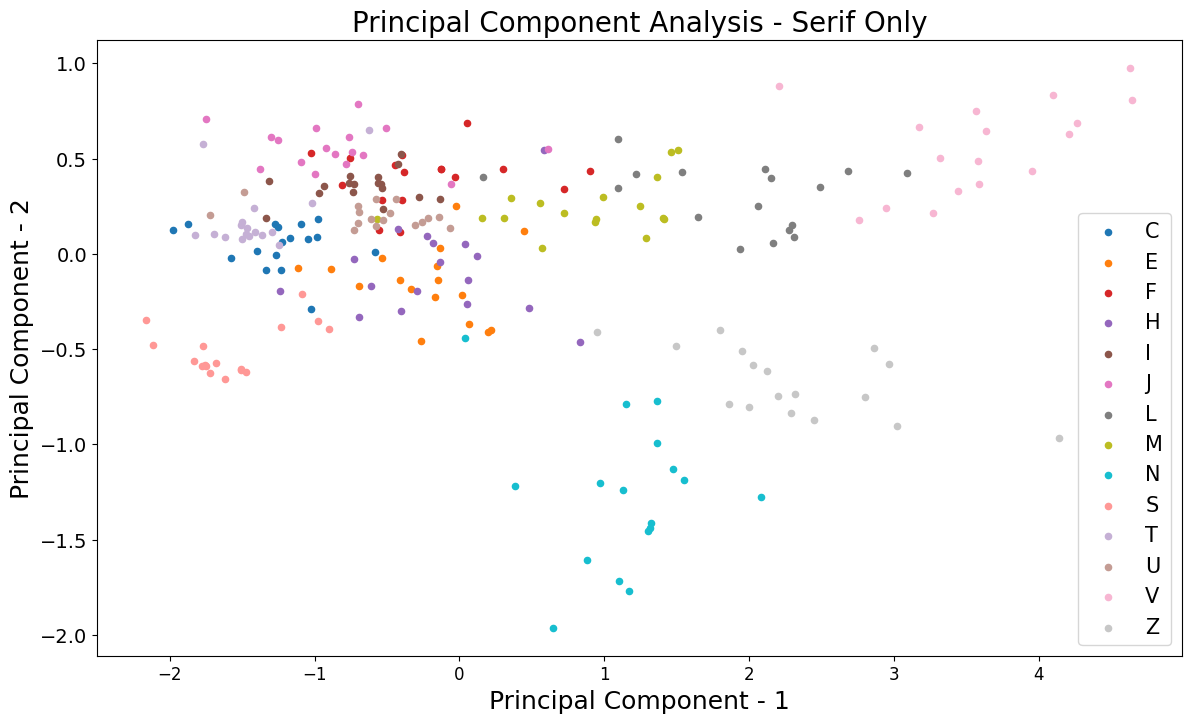

<Figure size 640x480 with 0 Axes>

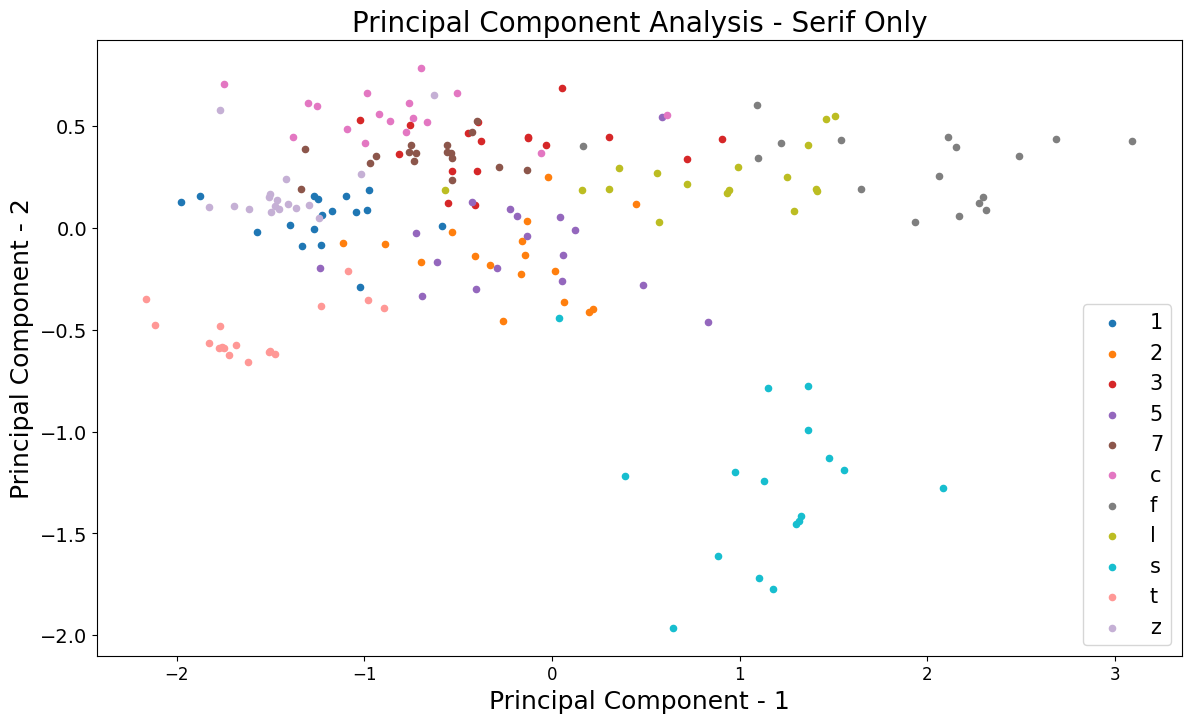

<Figure size 640x480 with 0 Axes>

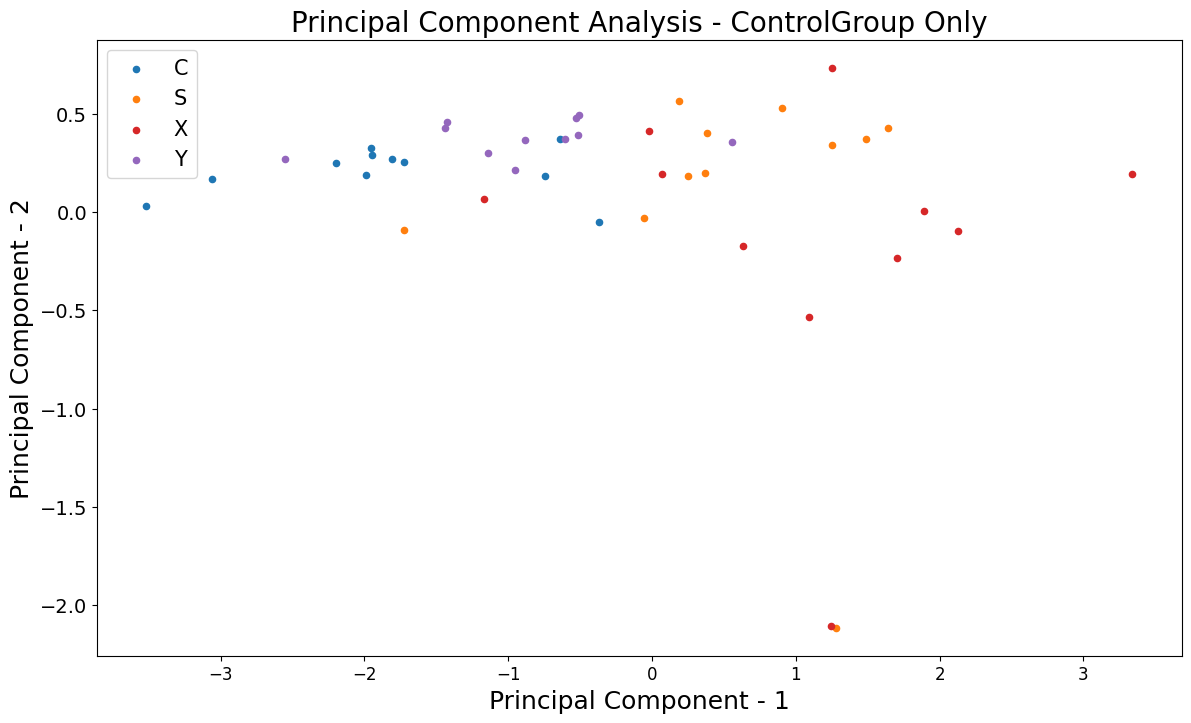

<Figure size 640x480 with 0 Axes>

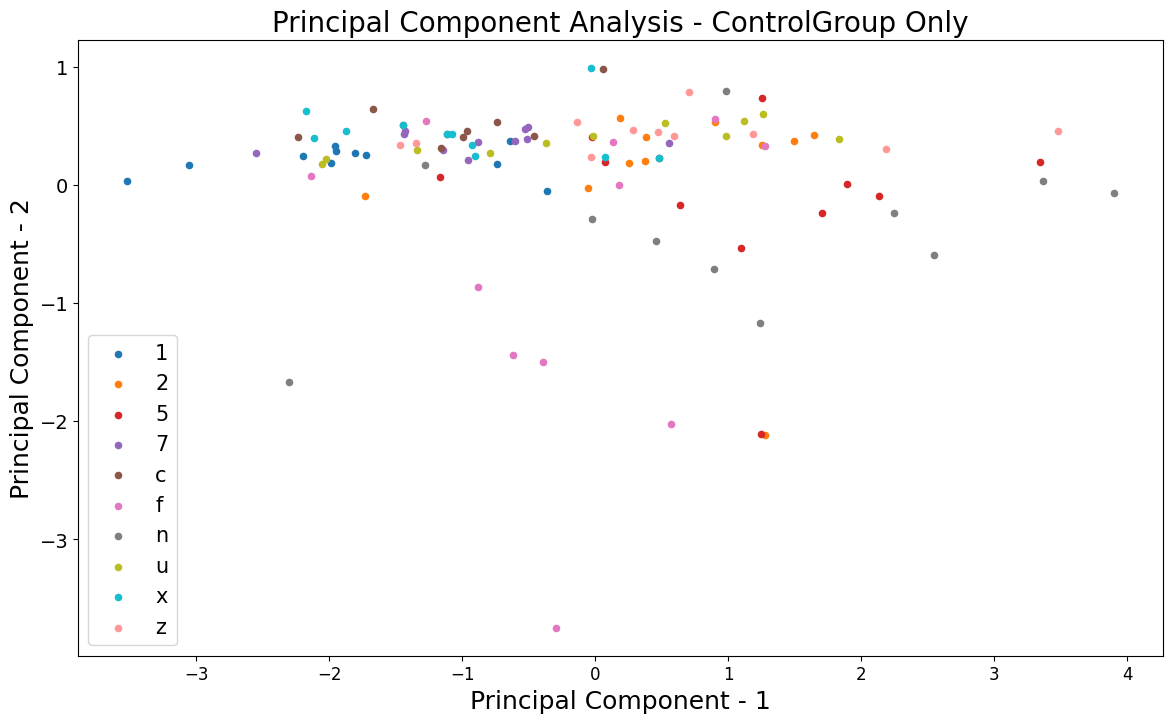

<Figure size 640x480 with 0 Axes>

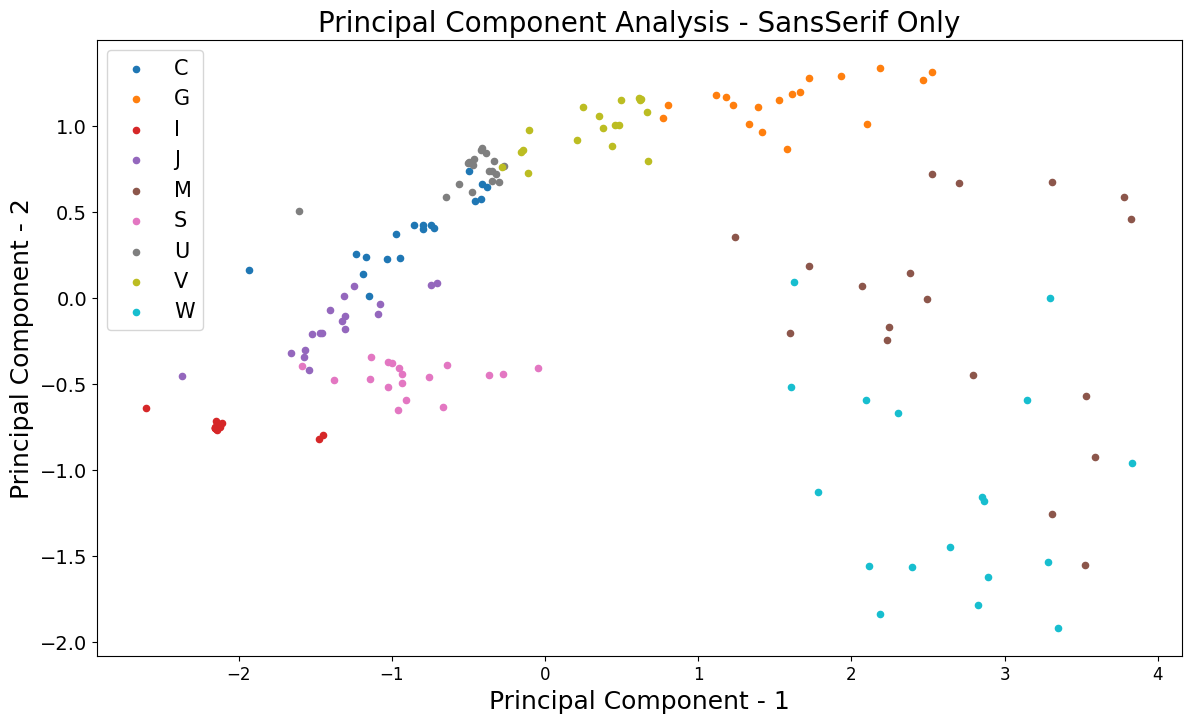

<Figure size 640x480 with 0 Axes>

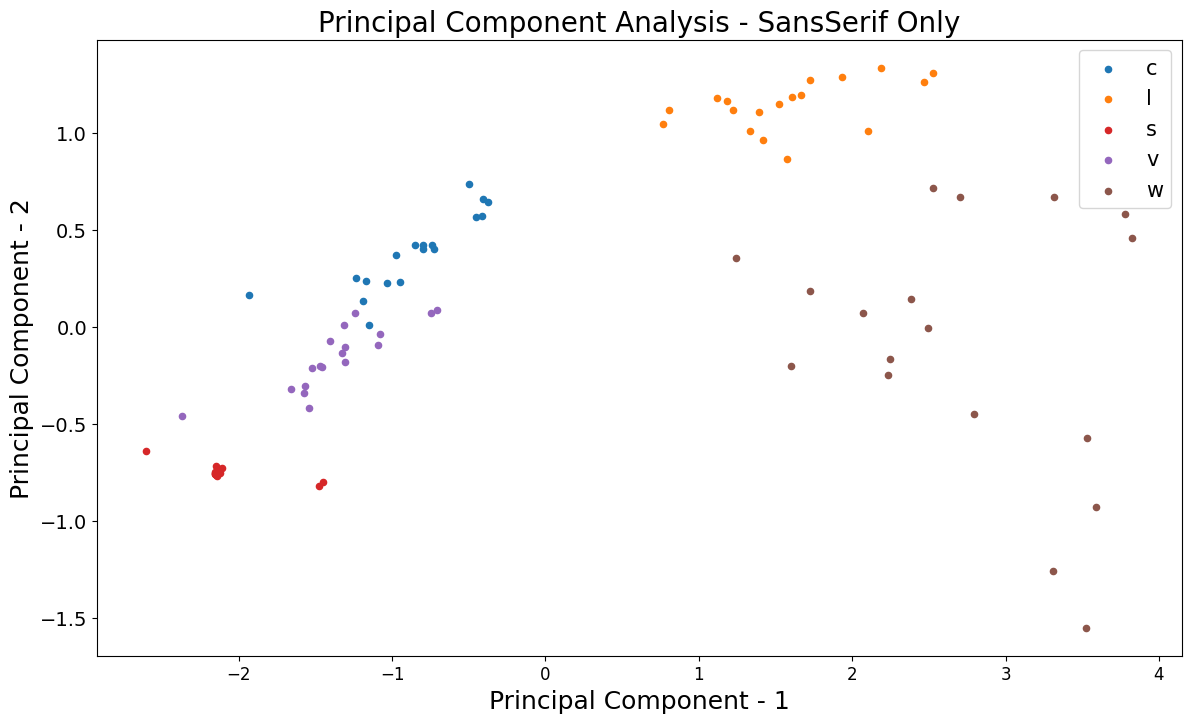

<Figure size 640x480 with 0 Axes>

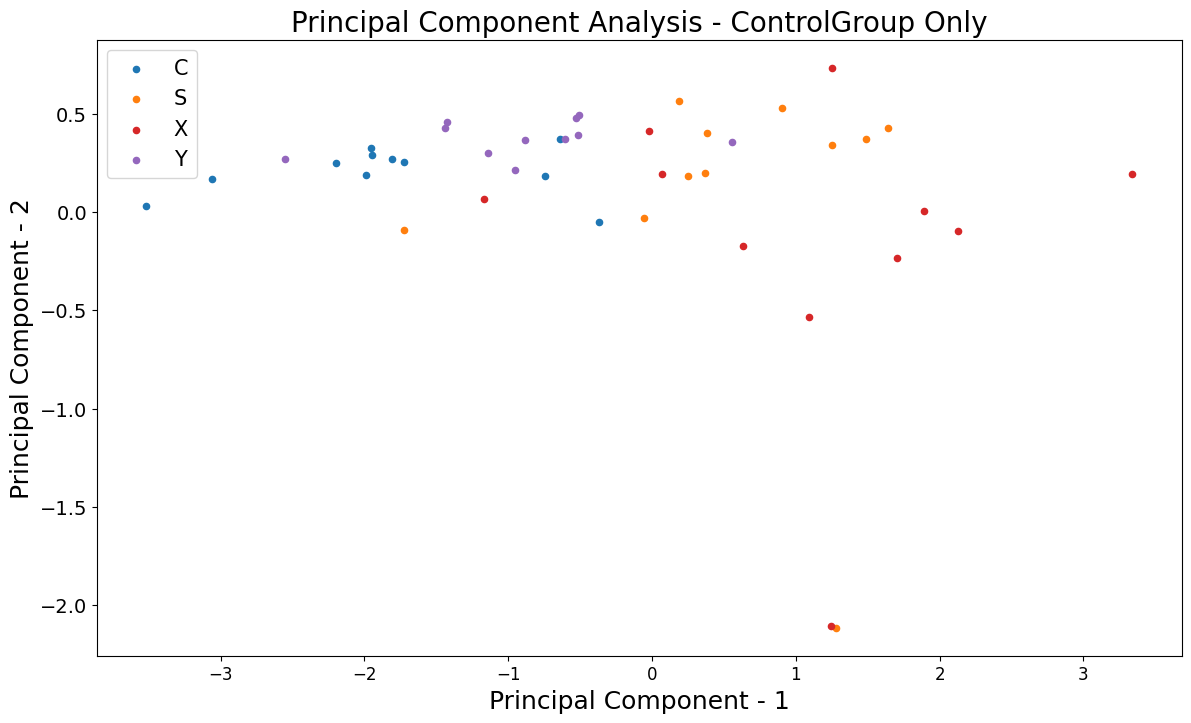

<Figure size 640x480 with 0 Axes>

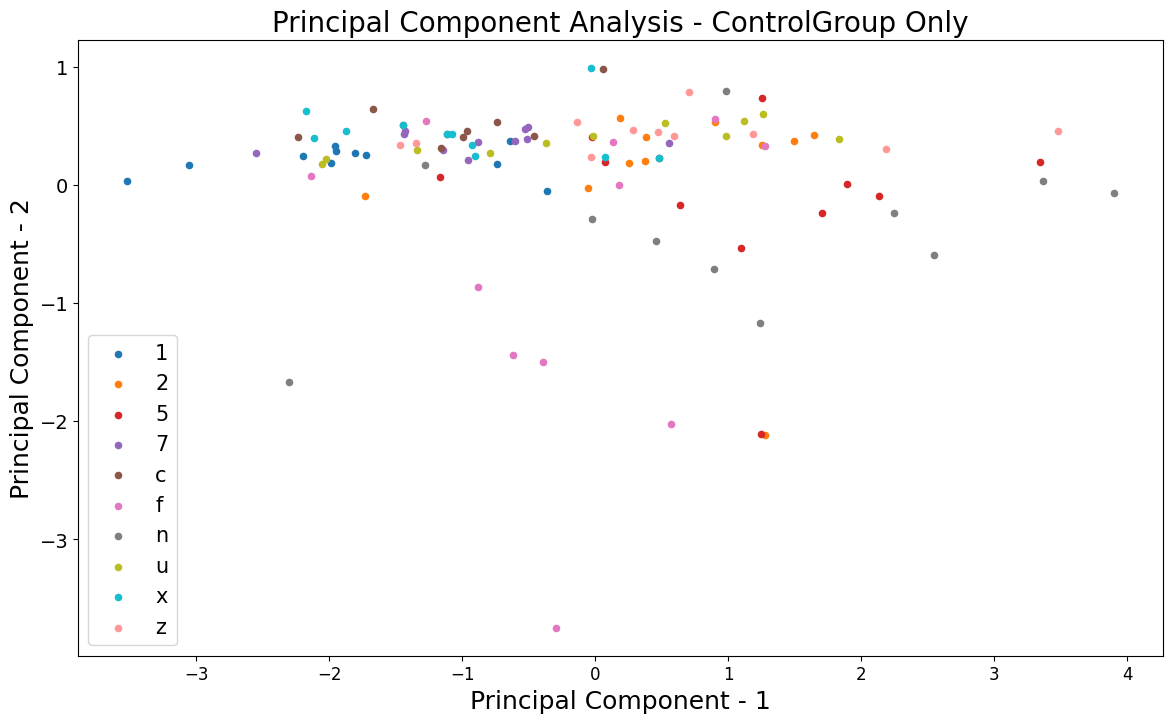

In [34]:
# Let's start with PCA (Principal Component Analysis)
from sklearn.decomposition import PCA

serif_data = data[data['Serif'] == True]
sans_data = data[data['SansSerif'] == True]


def plot_pca(components, uniques, grp, uppercase=False):
    if uppercase:
        uniques = uniques[uniques.str.isupper()]
    else:
        uniques = uniques[~uniques.str.isupper()]
        

    colors = ['#1f77b4', '#ff7f0e', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#ff9896', '#c5b0d5',
    '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5', '#ffbb78', '#98df8a', '#ffddff', '#aec7e8', '#ffb3b3', '#b3ffb3',
    '#ffd27f', '#ffccff', '#e6e6fa', '#d8bfd8', '#dda0dd', '#ee82ee', '#f08080']
    plt.figure()
    plt.figure(figsize=(14,8))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    plt.xlabel('Principal Component - 1',fontsize=18)
    plt.ylabel('Principal Component - 2',fontsize=18)
    plt.title(f"Principal Component Analysis - {grp} Only",fontsize=20)
    
    for i, target in enumerate(uniques):
        target_label = i 
        indicesToKeep = components['Character_Label'] == target_label
        plt.scatter(components.loc[indicesToKeep, 'PC 1'],
                    components.loc[indicesToKeep, 'PC 2'],
                    c=colors[i%len(colors)], s=20, label=target)

    plt.legend(uniques,prop={'size': 15})


def pca(grp, data, min_max=False, common_chars=True):
    grp_data = data[data[grp] == True]

    if common_chars:
        grp_characters = grp_data.groupby('Font')['Character'].unique()
        common_characters = set.intersection(*[set(chars) for chars in grp_characters])
        grp_data = grp_data[grp_data['Character'].isin(common_characters)]
    
    character_column = grp_data['Character']
    character_labels, uniques = pd.factorize(character_column)
    character_column = pd.Series(character_labels, name='Character_Label')
    
    grp_spectra = spectrum_amplitudes(grp_data)

    if min_max:
        grp_spectra, _ = apply_min_max(grp_spectra)
    
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(grp_spectra)

    # Create DataFrame and add character labels
    principal_Df = pd.DataFrame(data=principalComponents, columns=['PC 1', 'PC 2'])
    principal_Df['Character_Label'] = character_column.values
    
    print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')
    component_relation = pd.DataFrame(pca.components_, columns=grp_spectra.columns, index = ['PC 1','PC 2'])
    
    filtered_component_relation = component_relation.loc[:, (np.abs(component_relation) >= 0.15).any()]
    
    print(filtered_component_relation)
    print("------\n")
    plot_pca(principal_Df, uniques, grp ,True)
    plot_pca(principal_Df, uniques, grp, False)

#pca('Serif', data)
pca('Serif', data, min_max=True)

pca('ControlGroup', data, min_max=True)

#pca('SansSerif', data)
pca('SansSerif', data, min_max=True)

pca('ControlGroup', data, min_max=True)

['2' '3' '5' '7']
(184, 263)
Explained variation per principal component: [0.17711943 0.04321502 0.02559101 0.02402158 0.01794359 0.01779577
 0.01675169 0.01559652]
           -48        -8        -4        -3        -2         2         3  \
PC 1  0.065706  0.092808  0.083634  0.085886 -0.034044 -0.055602  0.093904   
PC 2 -0.009758  0.242172  0.283162 -0.348716  0.432104  0.297247 -0.386851   
PC 3 -0.097688 -0.049300  0.013872  0.039384 -0.032870  0.030345  0.093745   
PC 4 -0.020556  0.215983  0.319456  0.066362 -0.168532 -0.308729  0.107581   
PC 5  0.081344  0.091867  0.065393  0.028387 -0.008763 -0.019172  0.044502   
PC 6 -0.120972 -0.035842 -0.162309  0.102456  0.060709  0.135367  0.030632   
PC 7  0.026292 -0.071638 -0.070582  0.028535  0.114473  0.098893  0.002432   
PC 8  0.233322 -0.059134 -0.046310 -0.017532 -0.009233  0.028319  0.005215   

             4         5        13  
PC 1  0.059748  0.110514  0.030366  
PC 2  0.252818  0.042760 -0.010201  
PC 3  0.040199 -0.029

/var/folders/dg/d58kxwjd7sb729571k7wthh40000gn/T/ipykernel_2076/2322816159.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

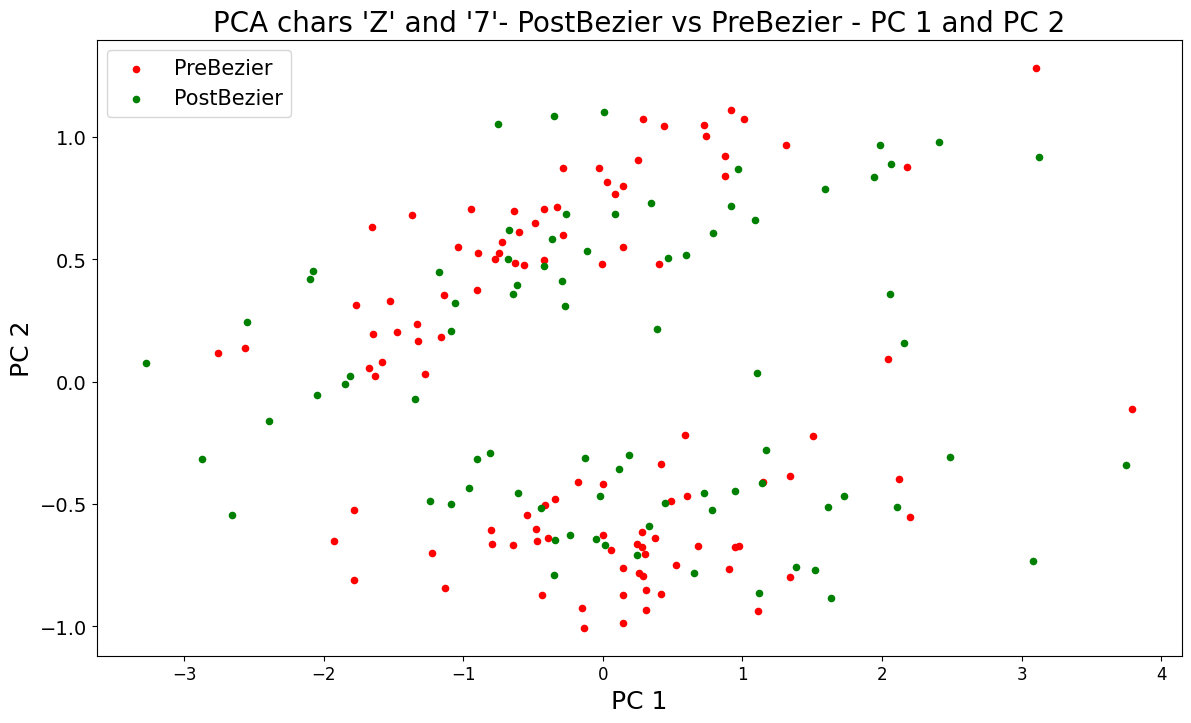

<Figure size 640x480 with 0 Axes>

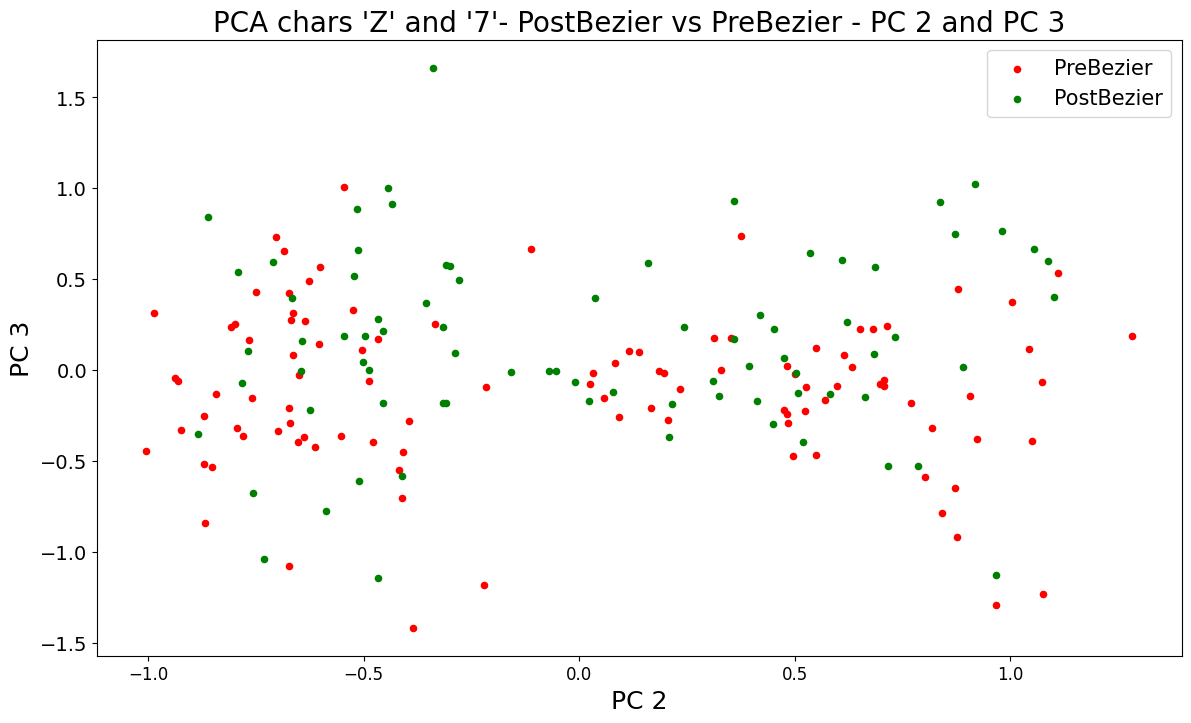

<Figure size 640x480 with 0 Axes>

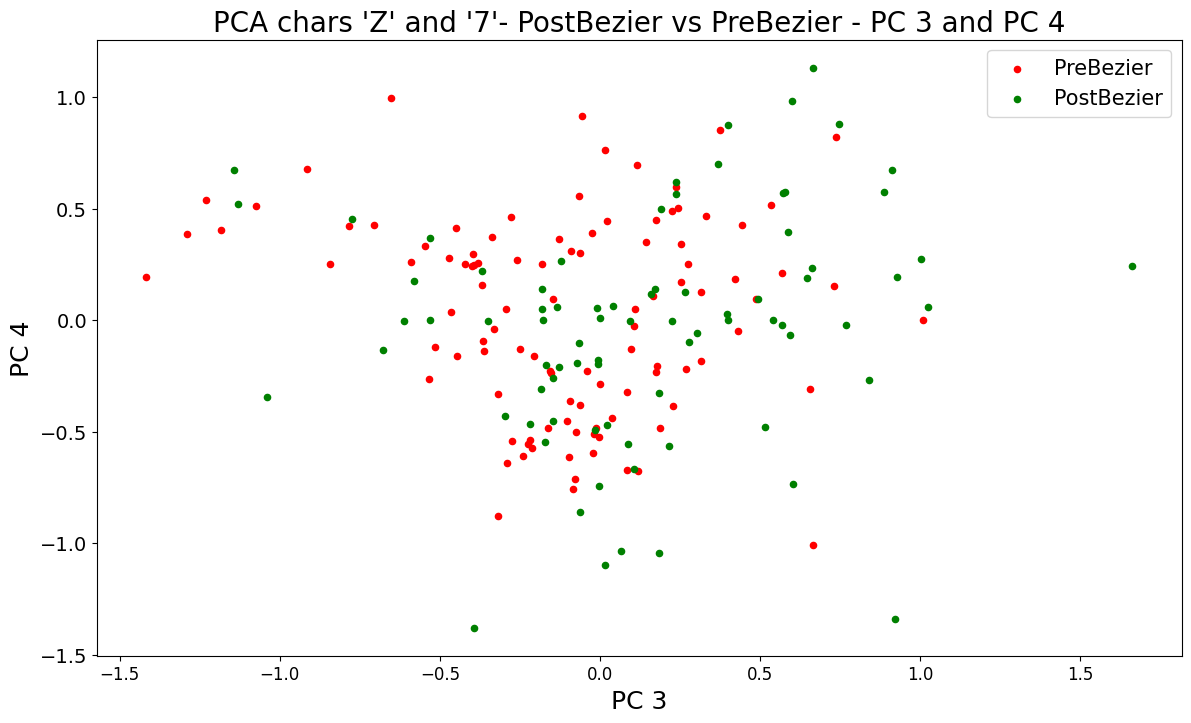

<Figure size 640x480 with 0 Axes>

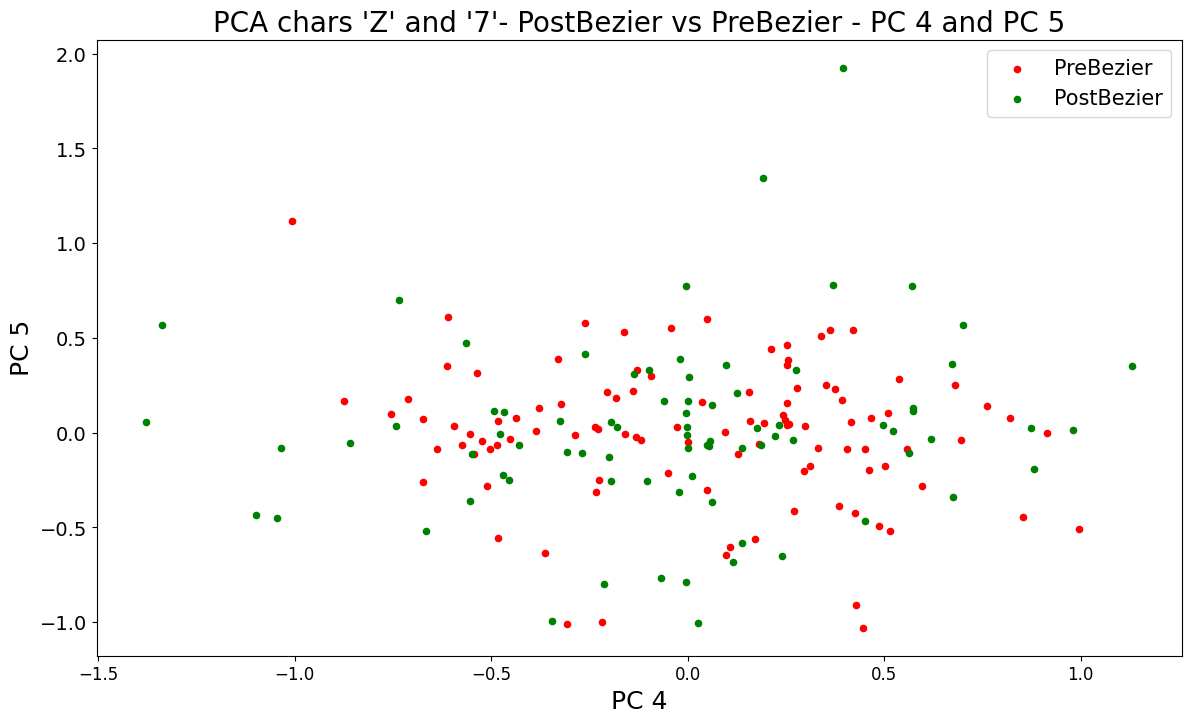

<Figure size 640x480 with 0 Axes>

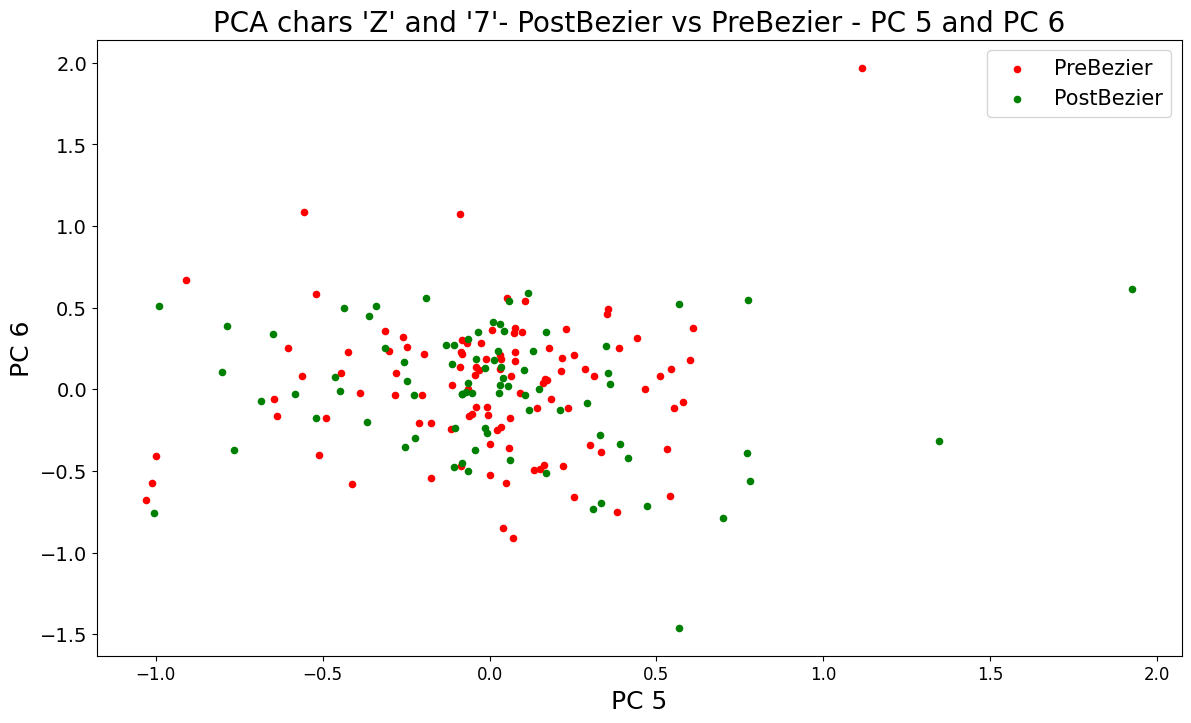

<Figure size 640x480 with 0 Axes>

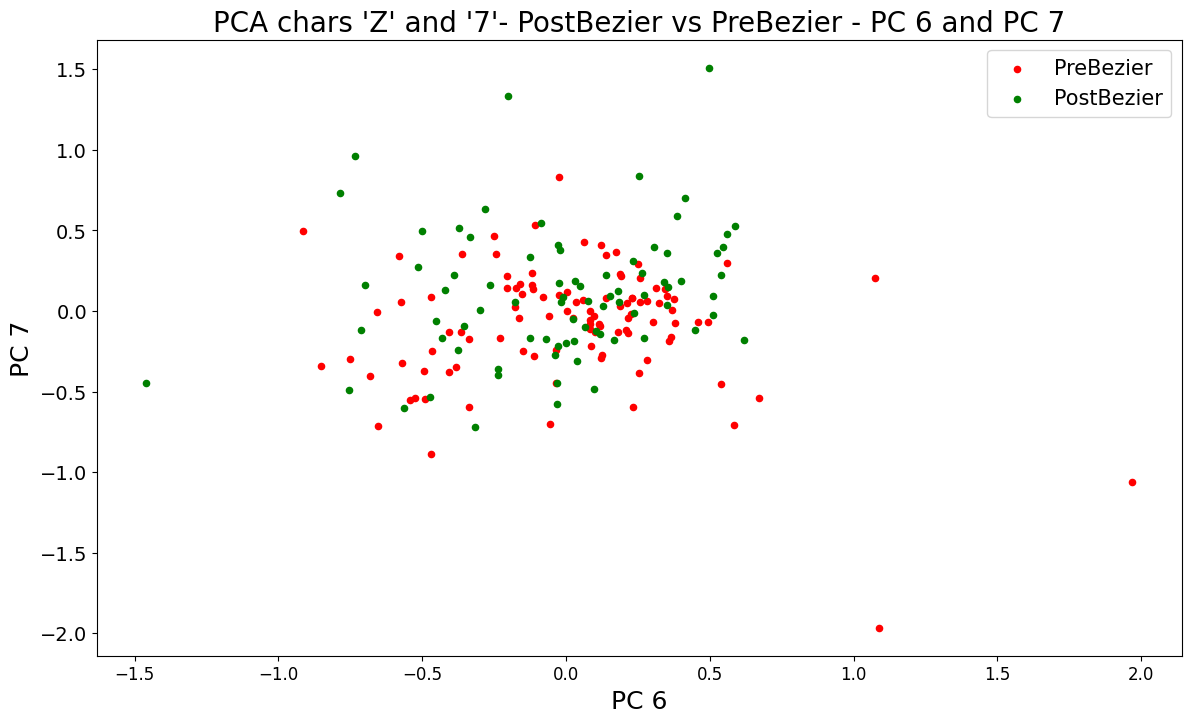

<Figure size 640x480 with 0 Axes>

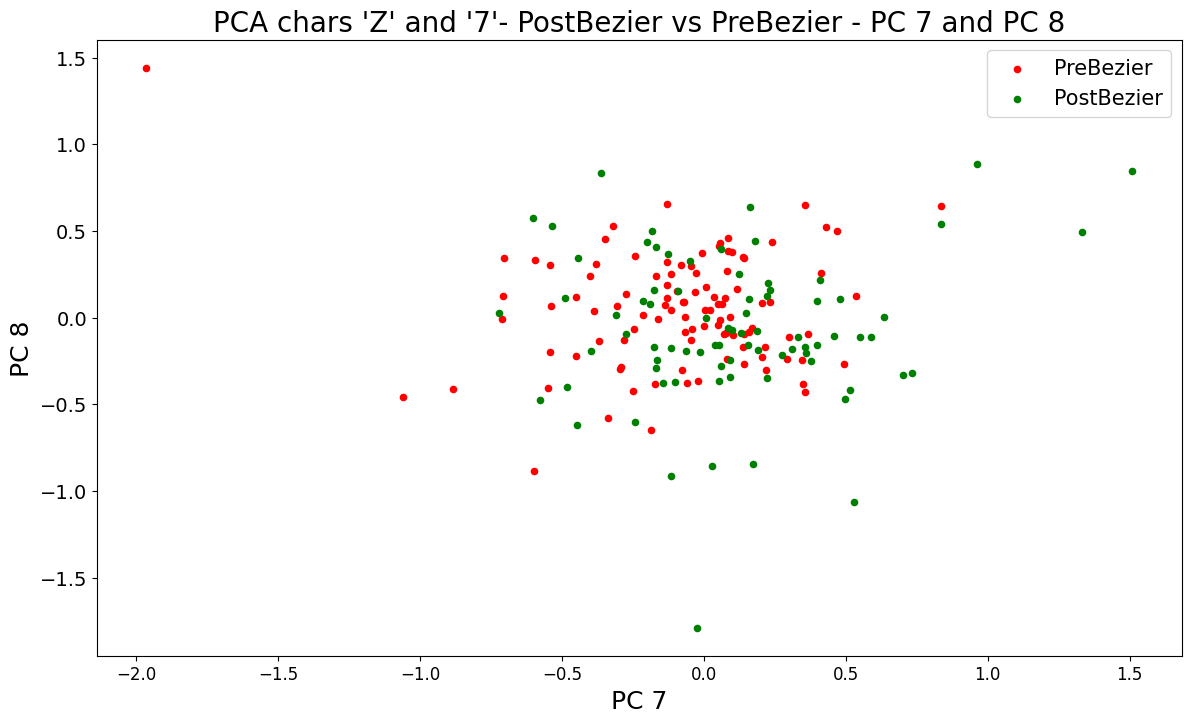

<Figure size 640x480 with 0 Axes>

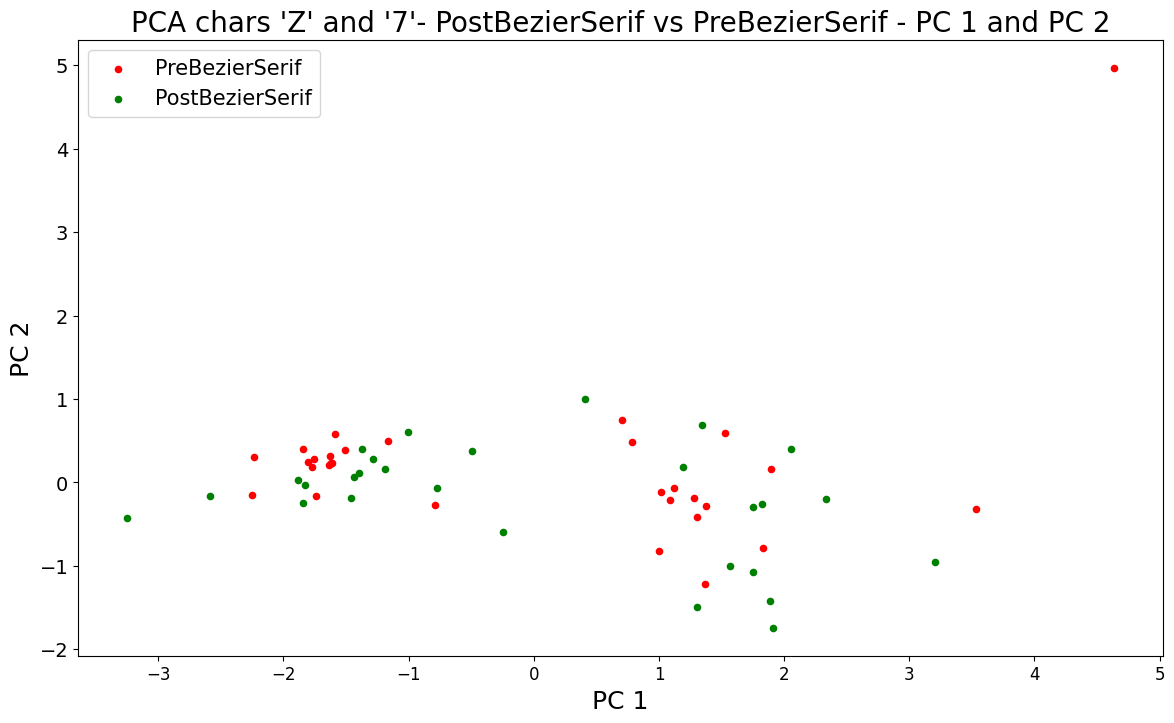

<Figure size 640x480 with 0 Axes>

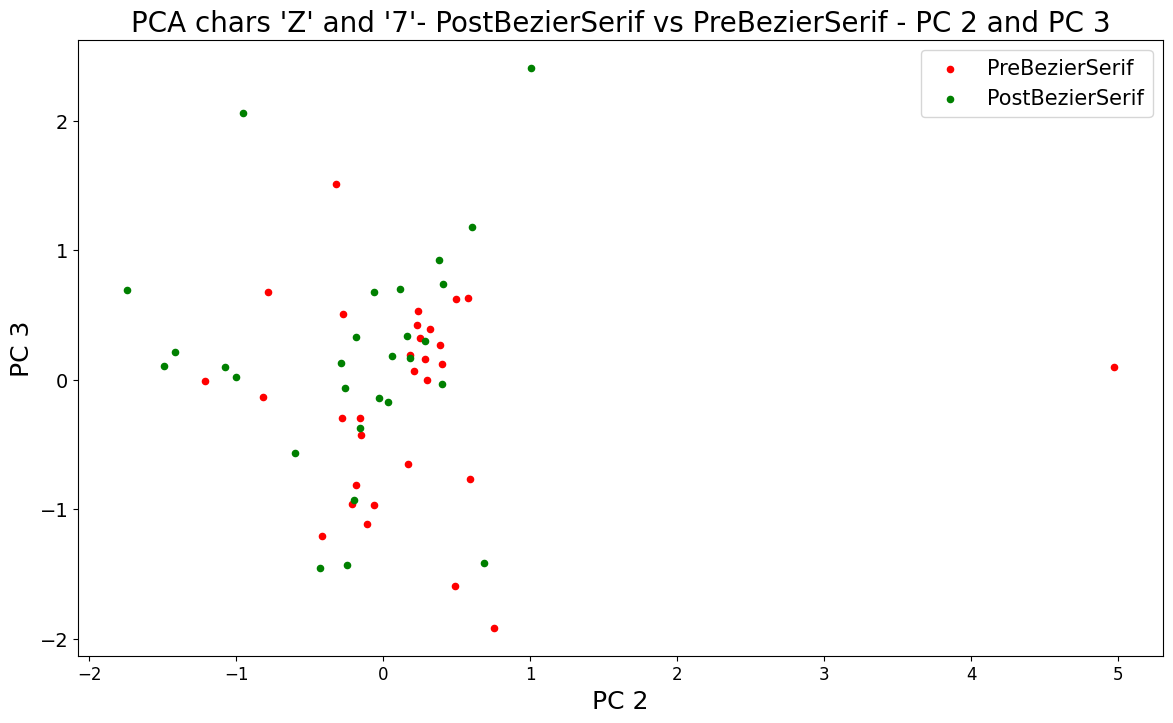

<Figure size 640x480 with 0 Axes>

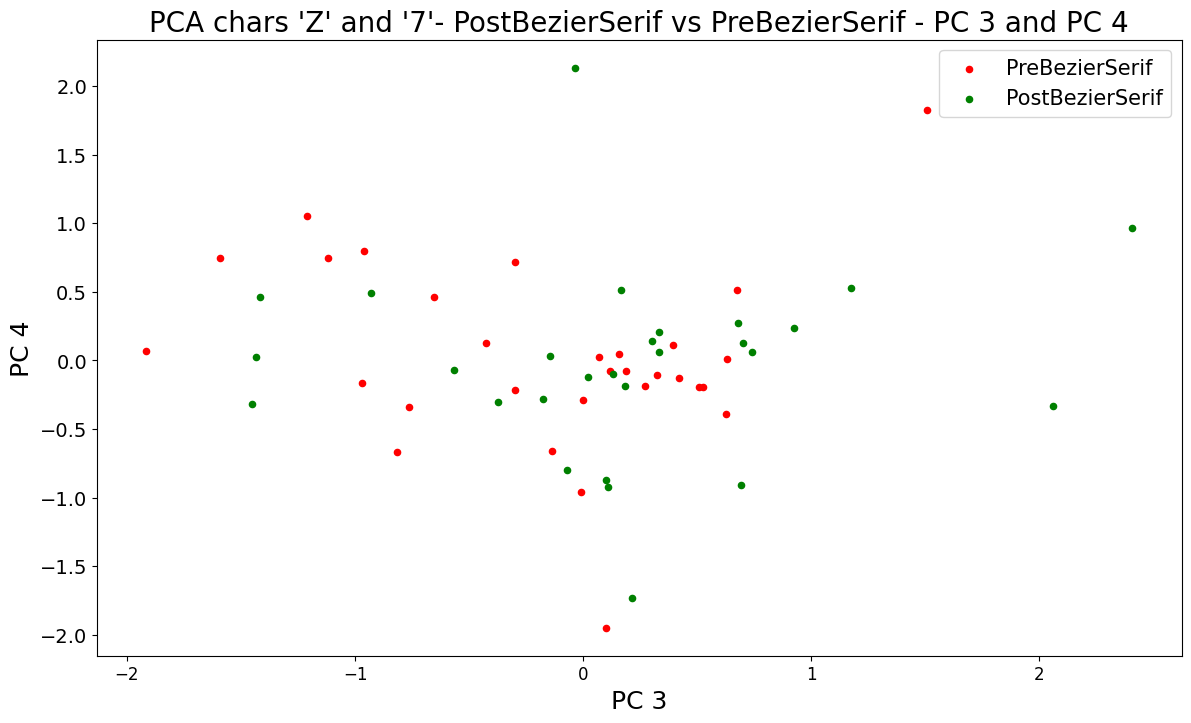

<Figure size 640x480 with 0 Axes>

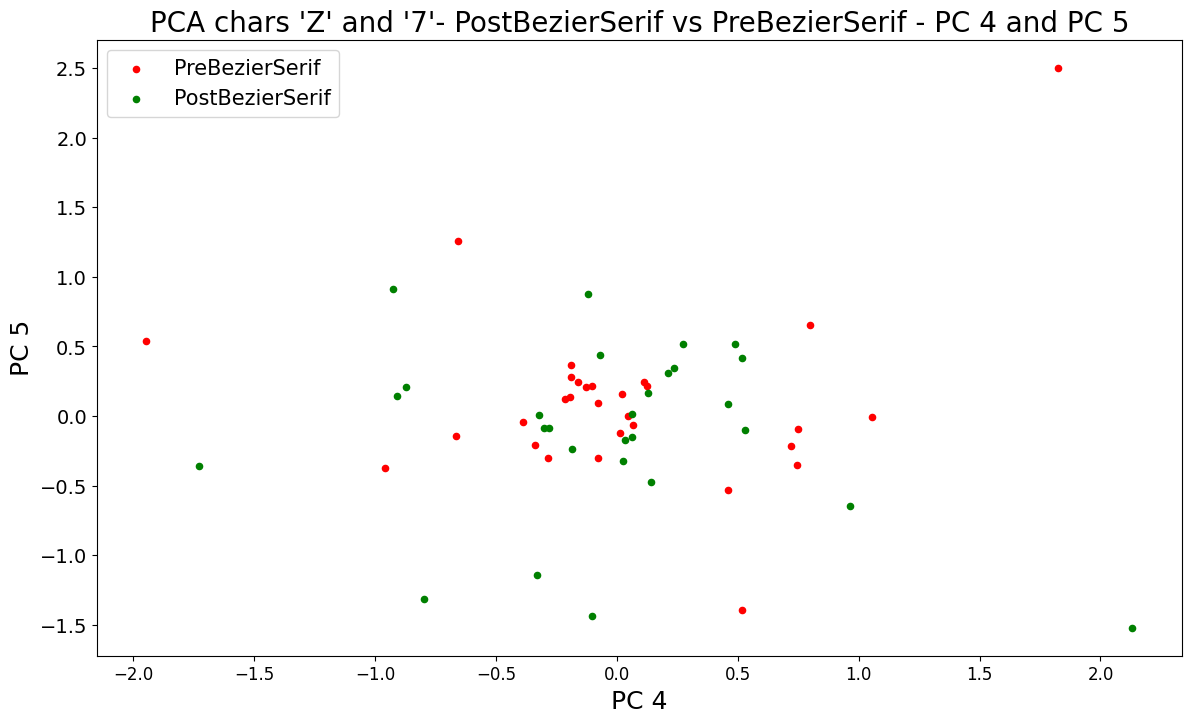

<Figure size 640x480 with 0 Axes>

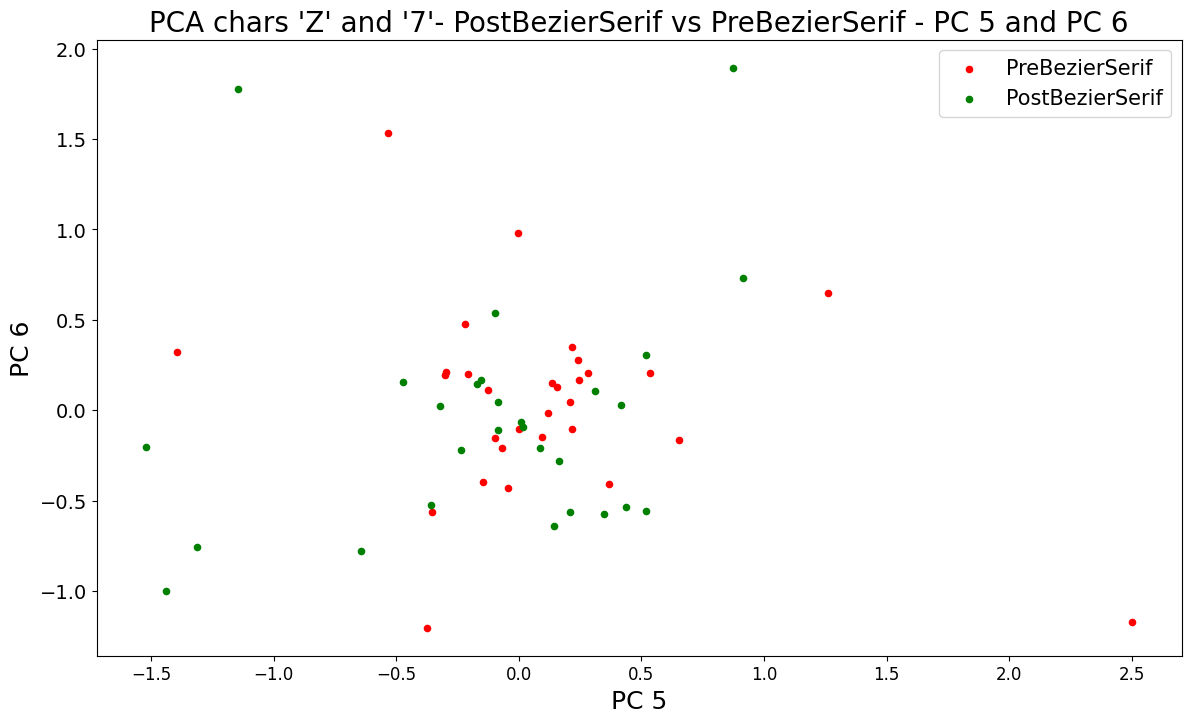

<Figure size 640x480 with 0 Axes>

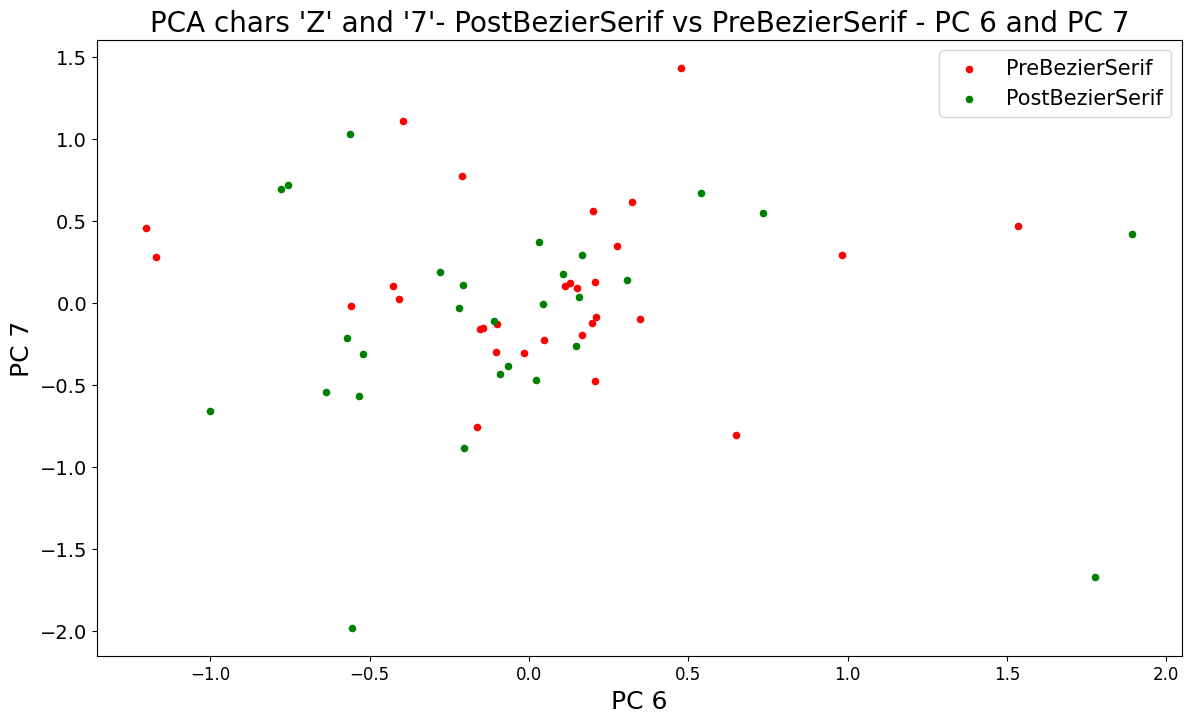

<Figure size 640x480 with 0 Axes>

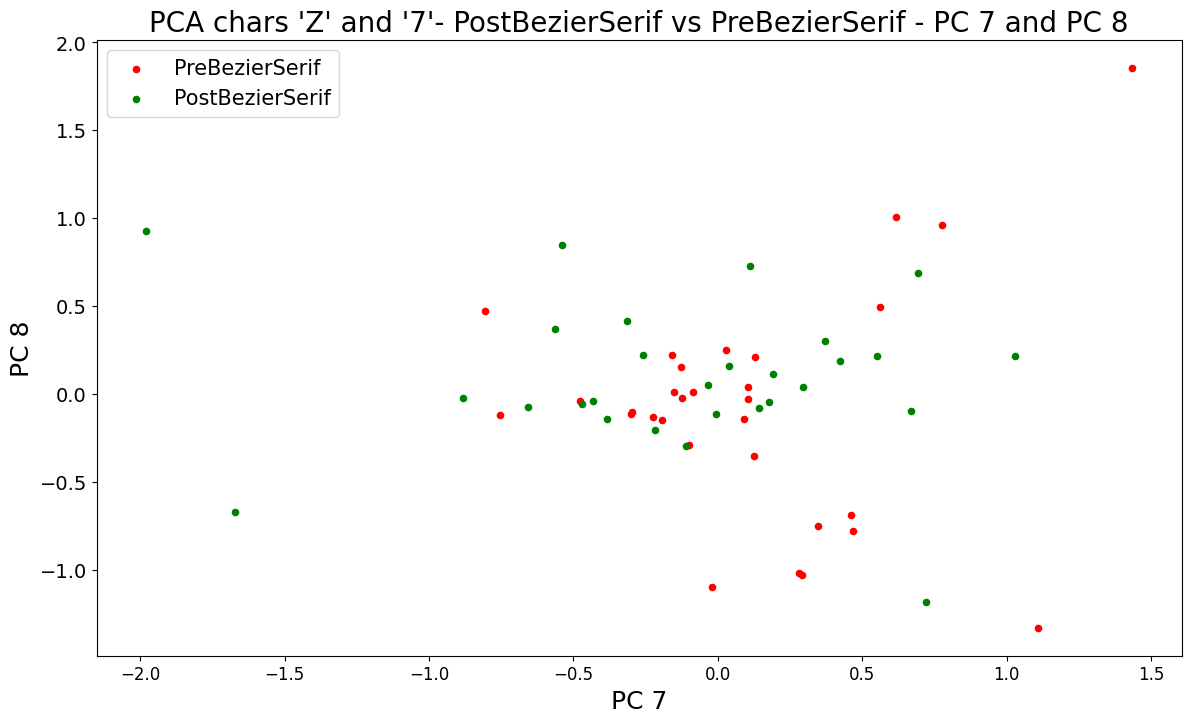

In [93]:
def plot_groups_pca(grp1, grp2, data, common=True, min_max=False, chars=None):
    combined = combine_groups(grp1, grp2, data, common)
    print(combined['Character'].unique())
    if chars is not None:
        combined = combined[combined['Character'].isin(chars)]
    
    grp_column = combined[grp1]
    print(combined.shape)
    
    font_labels, fonts = pd.factorize(grp_column)
    grp_column = pd.Series(font_labels, name='Font_Label')
    
    
    # Process spectra to get the amplitude for each frequency
    spectra = combined.loc[:, '-125':]
    spectra = apply_parse_complex(spectra)
    spectra = apply_abs(spectra)

    if min_max:
        spectra, _ = apply_min_max(spectra)
    
    pca = PCA(n_components=8)
    principalComponents = pca.fit_transform(spectra)
    
    
    components_Df = pd.DataFrame(data=principalComponents, columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8'])
    components_Df['Font_Label'] = grp_column.values


    print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')
    component_relation = pd.DataFrame(pca.components_, columns=spectra.columns, index = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8'])
    
    filtered_component_relation = component_relation.loc[:, (np.abs(component_relation) >= 0.2).any()]
    print(filtered_component_relation)
    # Plot the different combinations (does it make any sens to plot say PC 1 with PC 7 ??)
    for i in range(len(components_Df.columns) - 2):
        column1 = components_Df.columns[i]
        column2 = components_Df.columns[i+1]
        plt.figure()
        plt.figure(figsize=(14,8))
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=14)
        plt.xlabel(column1,fontsize=18)
        plt.ylabel(column2,fontsize=18)
        plt.title(f"PCA chars 'Z' and '7'- {grp1} vs {grp2} - {column1} and {column2}",fontsize=20)
        
        colors = ['r', 'g']
        
        for j, font in enumerate(fonts):
            font_label = j
            indicesToKeep = (components_Df['Font_Label'] == font_label)
            #print(f"Plotting points for character with font label {font} in color {[j % len(colors)]}")
            plt.scatter(components_Df.loc[indicesToKeep, column1],
                        components_Df.loc[indicesToKeep, column2],
                        c=colors[j % len(colors)], s=20, label=font )
        
        plt.legend([grp2, grp1],prop={'size': 15})
        

# Let's try PCA with different groups

#plot_groups_pca('Serif', 'SansSerif', data, min_max=True, chars={'U'})
#plot_groups_pca('Serif', 'SansSerif', data, min_max=True)
#plot_groups_pca('LookAlike', 'ControlGroup', min_max=True)
plot_groups_pca('PostBezier', 'PreBezier', data_subgrps, min_max=True)
plot_groups_pca('PostBezierSerif', 'PreBezierSerif', data_subgrps, min_max=True, chars={'7', 'Z'})

(184, 259)


<Figure size 640x480 with 0 Axes>

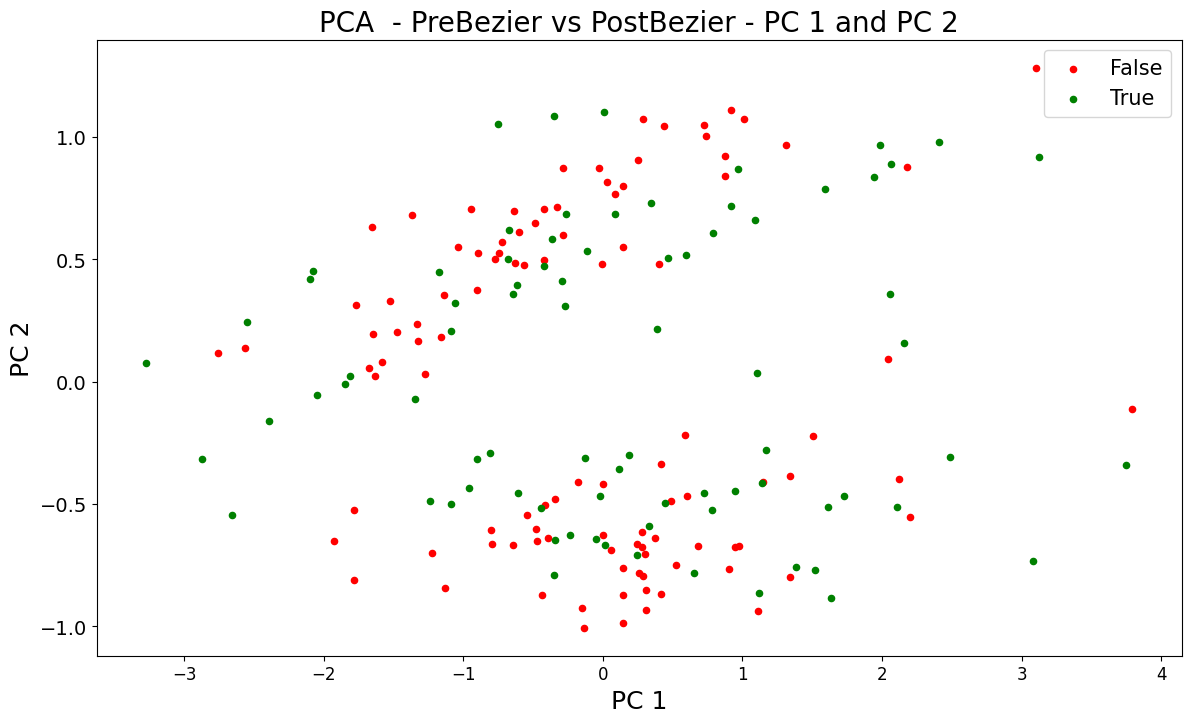

<Figure size 640x480 with 0 Axes>

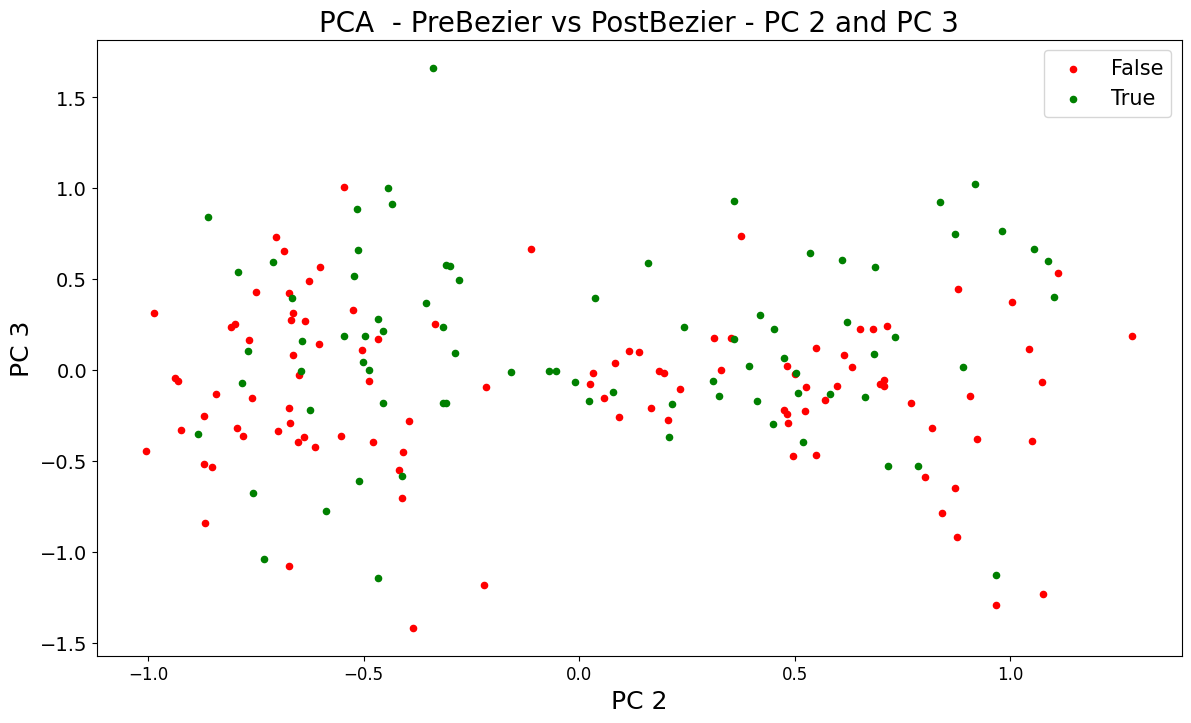

<Figure size 640x480 with 0 Axes>

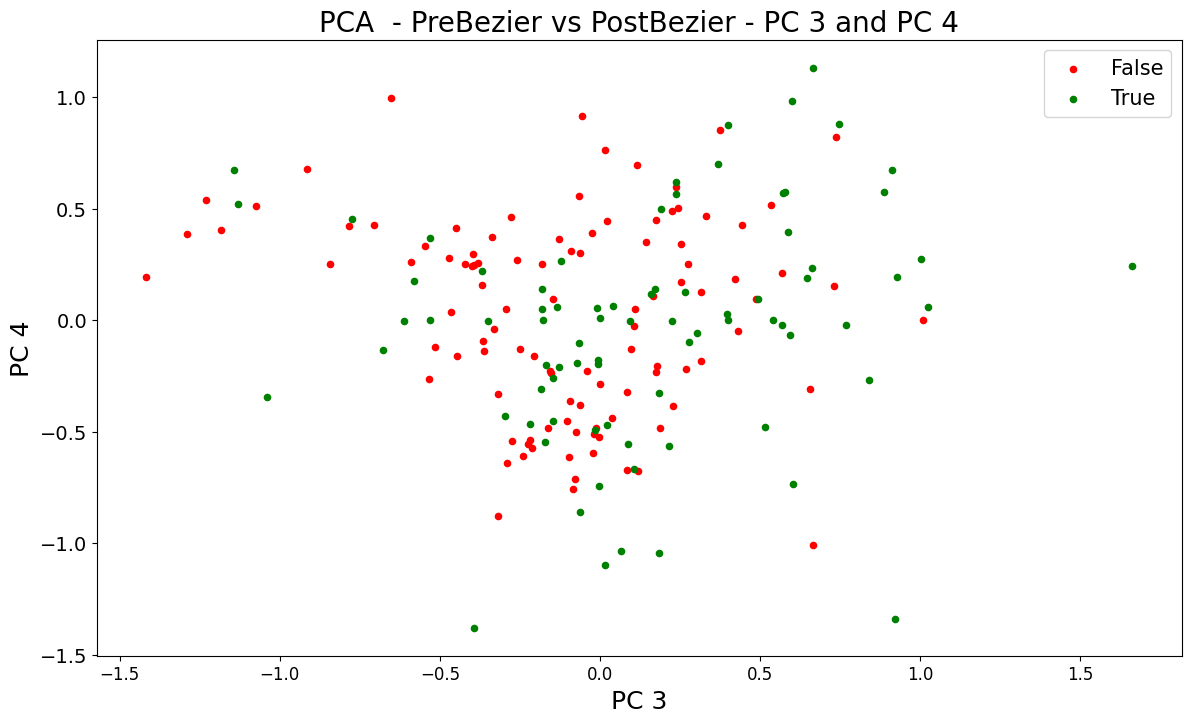

<Figure size 640x480 with 0 Axes>

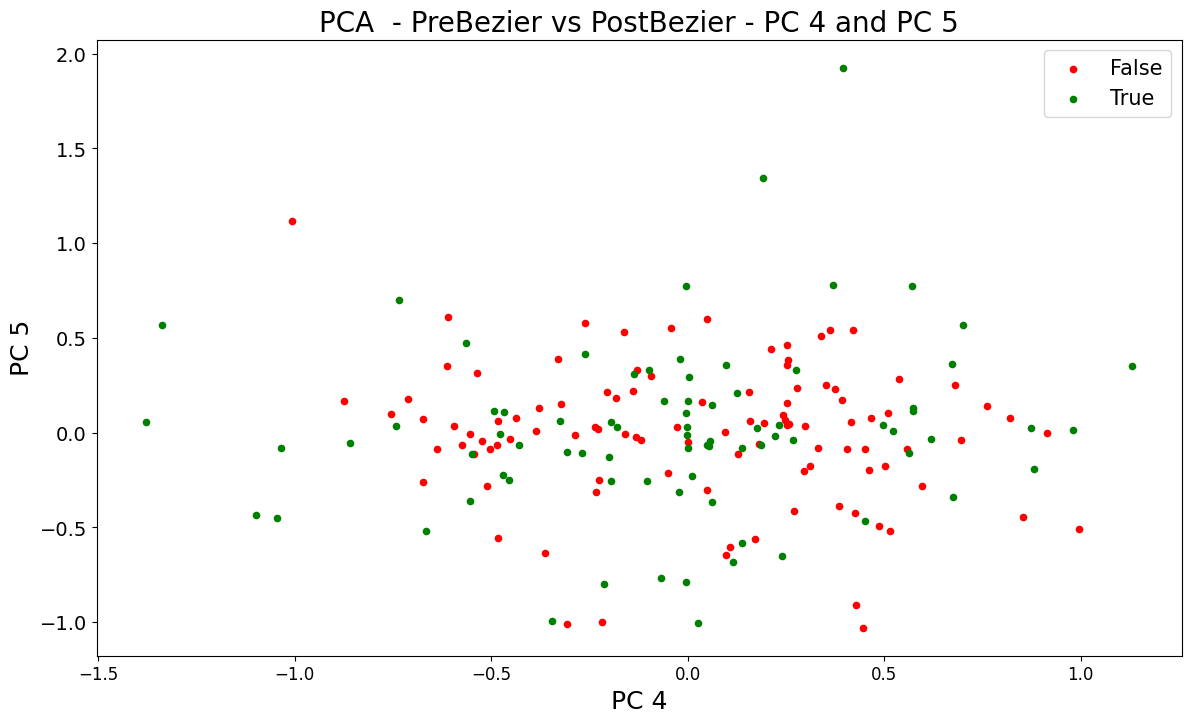

<Figure size 640x480 with 0 Axes>

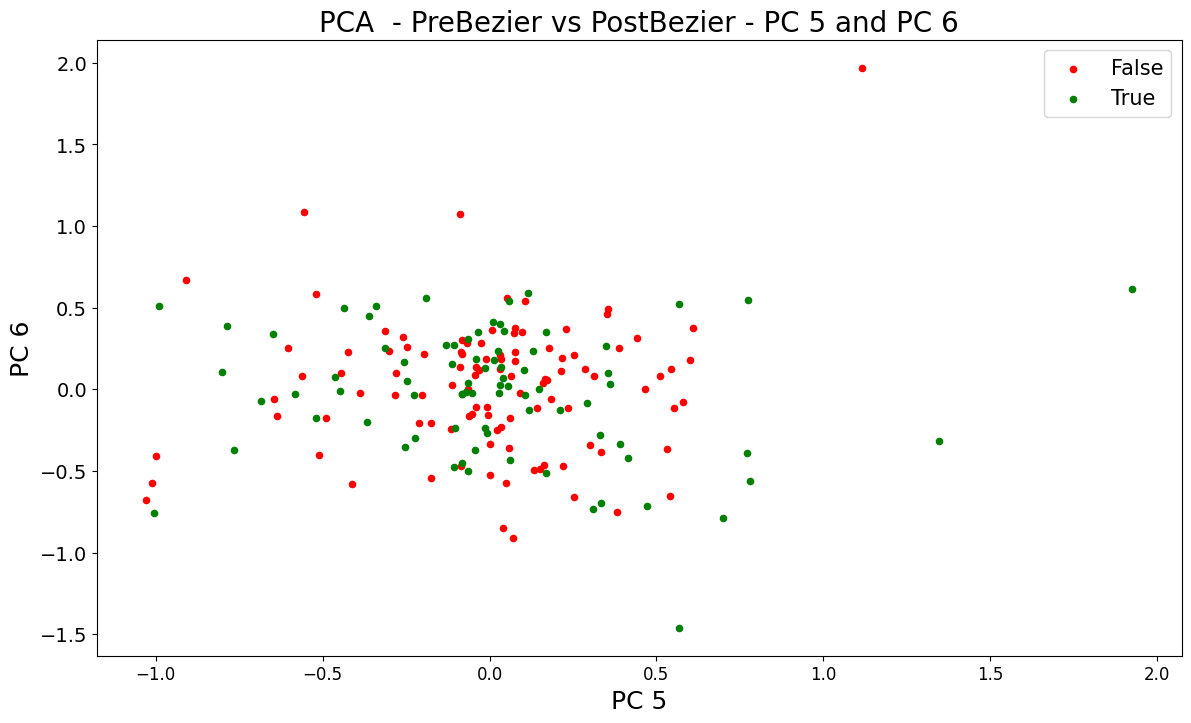

<Figure size 640x480 with 0 Axes>

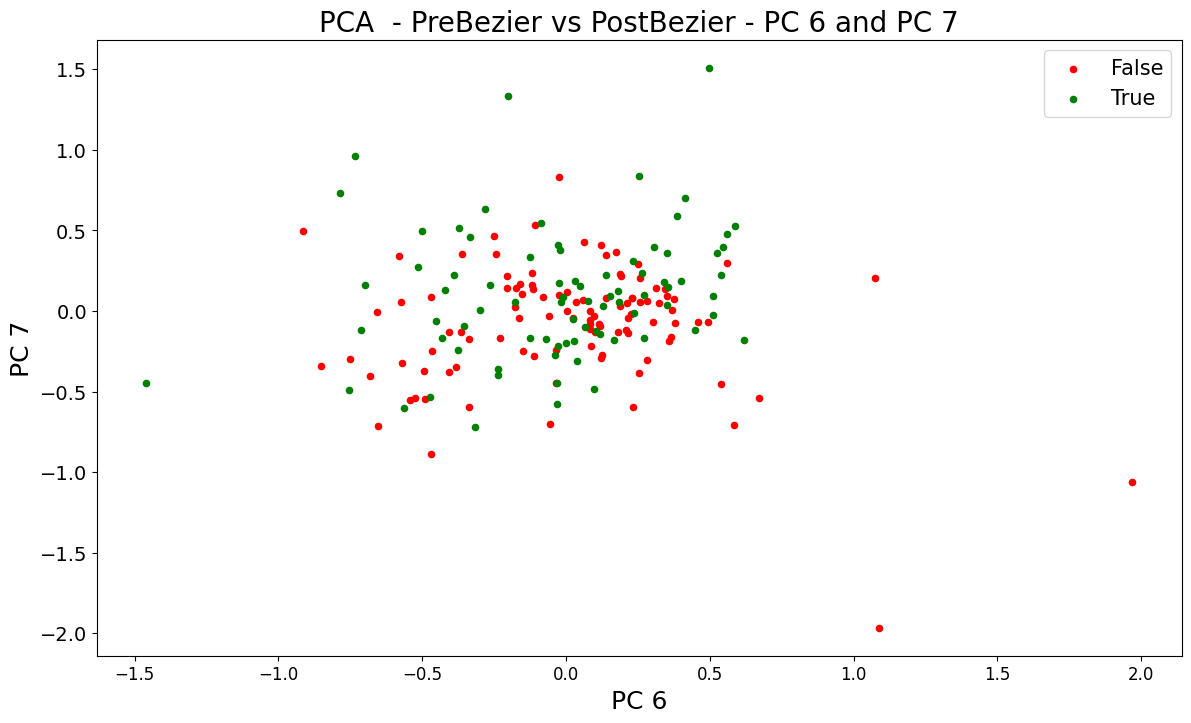

<Figure size 640x480 with 0 Axes>

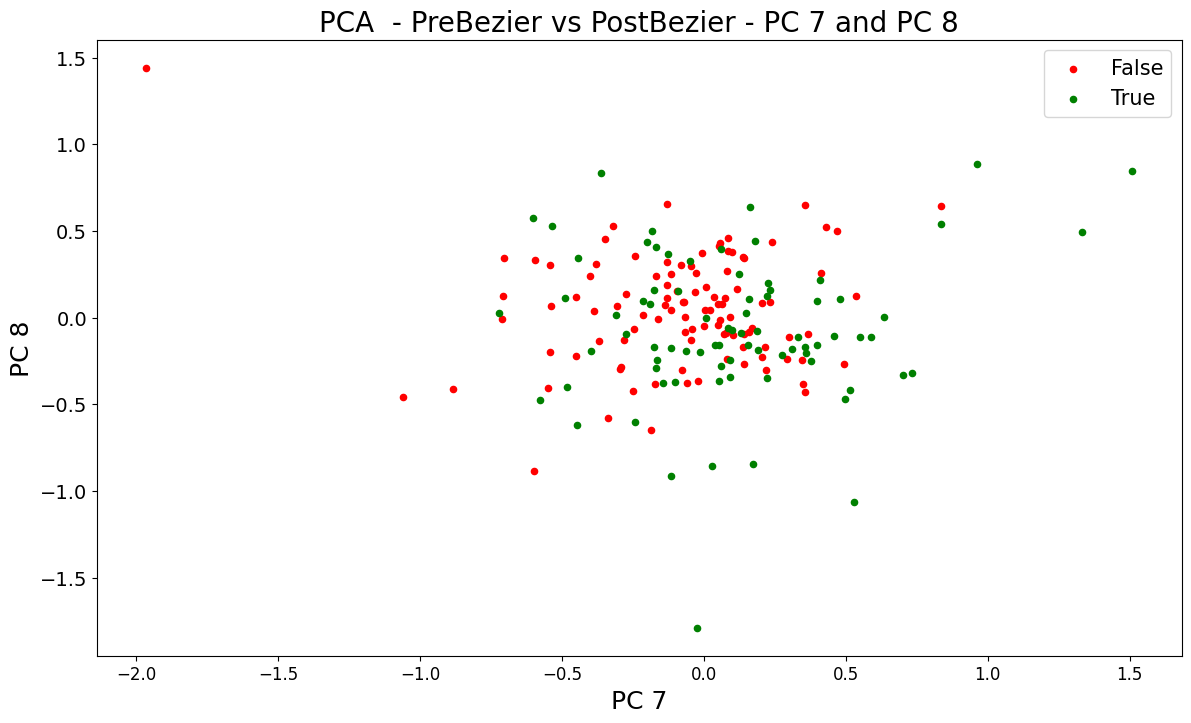

In [7]:
# Now let's compare PreBezier and PostBezier

plot_groups_pca('PreBezier', 'PostBezier', min_max=True)

In [8]:
# What if keep all characters and not only the ones common to all the used fonts?

#plot_groups_pca('Serif', 'SansSerif', common=False)

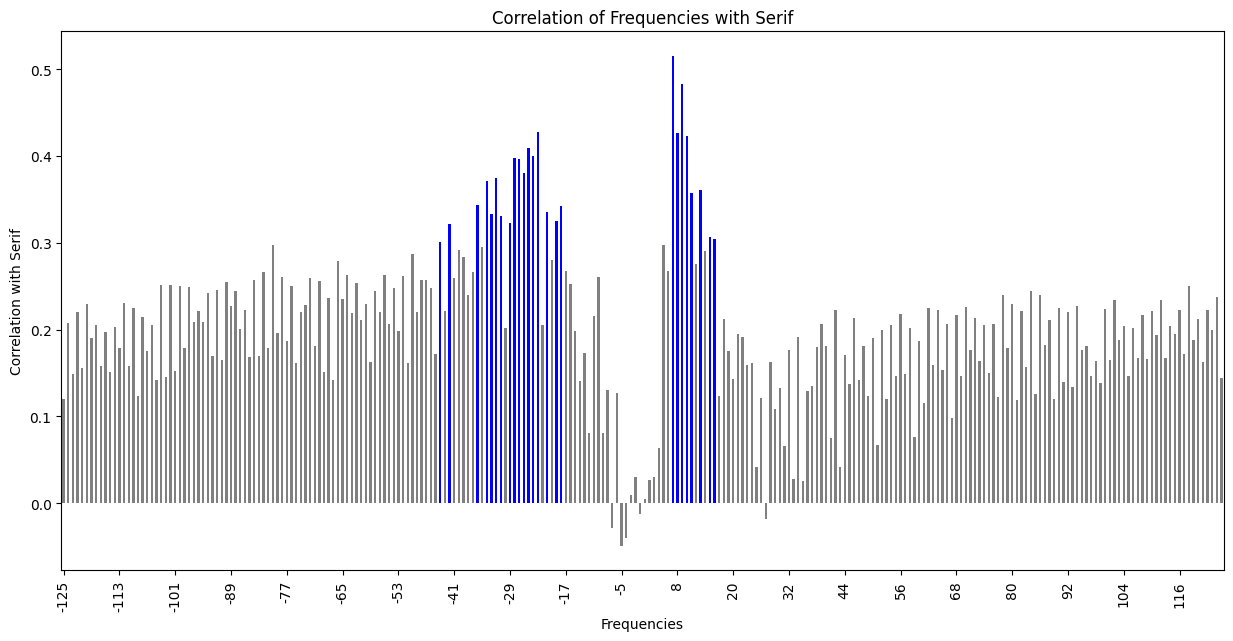

Highest correlation for frequencies:
Frequency: -19, Correlation: 0.3246509319288885
Frequency: -31, Correlation: 0.33063596383199323
Frequency: -33, Correlation: 0.33282837906851903
Frequency: -21, Correlation: 0.33604129733227117
Frequency: -18, Correlation: 0.342085029324273
Frequency: -36, Correlation: 0.34376872080082327
Frequency: 11, Correlation: 0.3570948453882441
Frequency: 13, Correlation: 0.36106881476686575
Frequency: -34, Correlation: 0.37107011143864727
Frequency: -32, Correlation: 0.3744302728871803
Frequency: -26, Correlation: 0.3801997983236577
Frequency: -27, Correlation: 0.3968741699814216
Frequency: -28, Correlation: 0.39809984581461805
Frequency: -24, Correlation: 0.40003568100693143
Frequency: -25, Correlation: 0.40868336023601143
Frequency: 10, Correlation: 0.4228506818986651
Frequency: 8, Correlation: 0.42658980358303206
Frequency: -23, Correlation: 0.42791620214140785
Frequency: 9, Correlation: 0.48325504798631674
Frequency: 7, Correlation: 0.5153209860999087


In [31]:
# Let's explore other methos

# First, let's see if we can determine a correlation between specific frequencies and the information Serif/Sans

combined = data[(data['Serif'] == True) | (data['SansSerif'] == True)]

serif_column = combined['Serif']
sans_column = combined['SansSerif']

# Process spectra to get the amplitude for each frequency
spectra = combined.loc[:, '-125':]
spectra = apply_parse_complex(spectra)
spectra = apply_abs(spectra)
#print(spectra.shape)
#print(serif_column.shape)


combined = pd.concat([spectra, serif_column], axis=1)

correlation = combined.corr()['Serif']

combined = pd.concat([spectra, sans_column], axis=1)
correlation_sans = combined.corr()['SansSerif']

# Remove correlation of Serif with Serif and Sans with Sans
correlation = correlation.drop('Serif')
correlation_sans = correlation_sans.drop('SansSerif')

def plot_corr(correlation, title):
    plt.figure(figsize=(15, 7))
    top_20_indices = correlation.nlargest(25).index
    colors = ['blue' if idx in top_20_indices else 'grey' for idx in correlation.index]
    correlation.plot(kind='bar', color=colors)
    plt.xlabel('Frequencies')
    plt.ylabel(title)
    plt.title('Correlation of Frequencies with Serif')
    num_ticks = 20
    step = len(correlation) // num_ticks
    ticks = np.arange(0, len(correlation), step)
    
    plt.xticks(ticks=ticks, labels=correlation.index[ticks], rotation=90) 
    plt.show()


plot_corr(correlation, 'Correlation with Serif')
#plot_corr(correlation_sans, 'Correlation with SansSerif')

# The 10 highest correlation frequencies are:
indices = np.argsort(correlation)[-20:]
print("Highest correlation for frequencies:")
for i in indices:
    print(f"Frequency: {correlation.index[i]}, Correlation: {correlation.iloc[i]}")

# It seems lower frequencies have a low correlation. Maybe try to exclude these frequencies in later analyses

True means the font is Serif, otherwise it is SansSerif 
Training data shape: (350, 259)
Test data shape: (90, 255)
knn
Confusion Matrix:
[[24  6]
 [17 43]]

Classification Report using knn:
              precision    recall  f1-score   support

           0       0.59      0.80      0.68        30
           1       0.88      0.72      0.79        60

    accuracy                           0.74        90
   macro avg       0.73      0.76      0.73        90
weighted avg       0.78      0.74      0.75        90





True means the font is Serif, otherwise it is SansSerif 
Training data shape: (350, 259)
Test data shape: (90, 255)


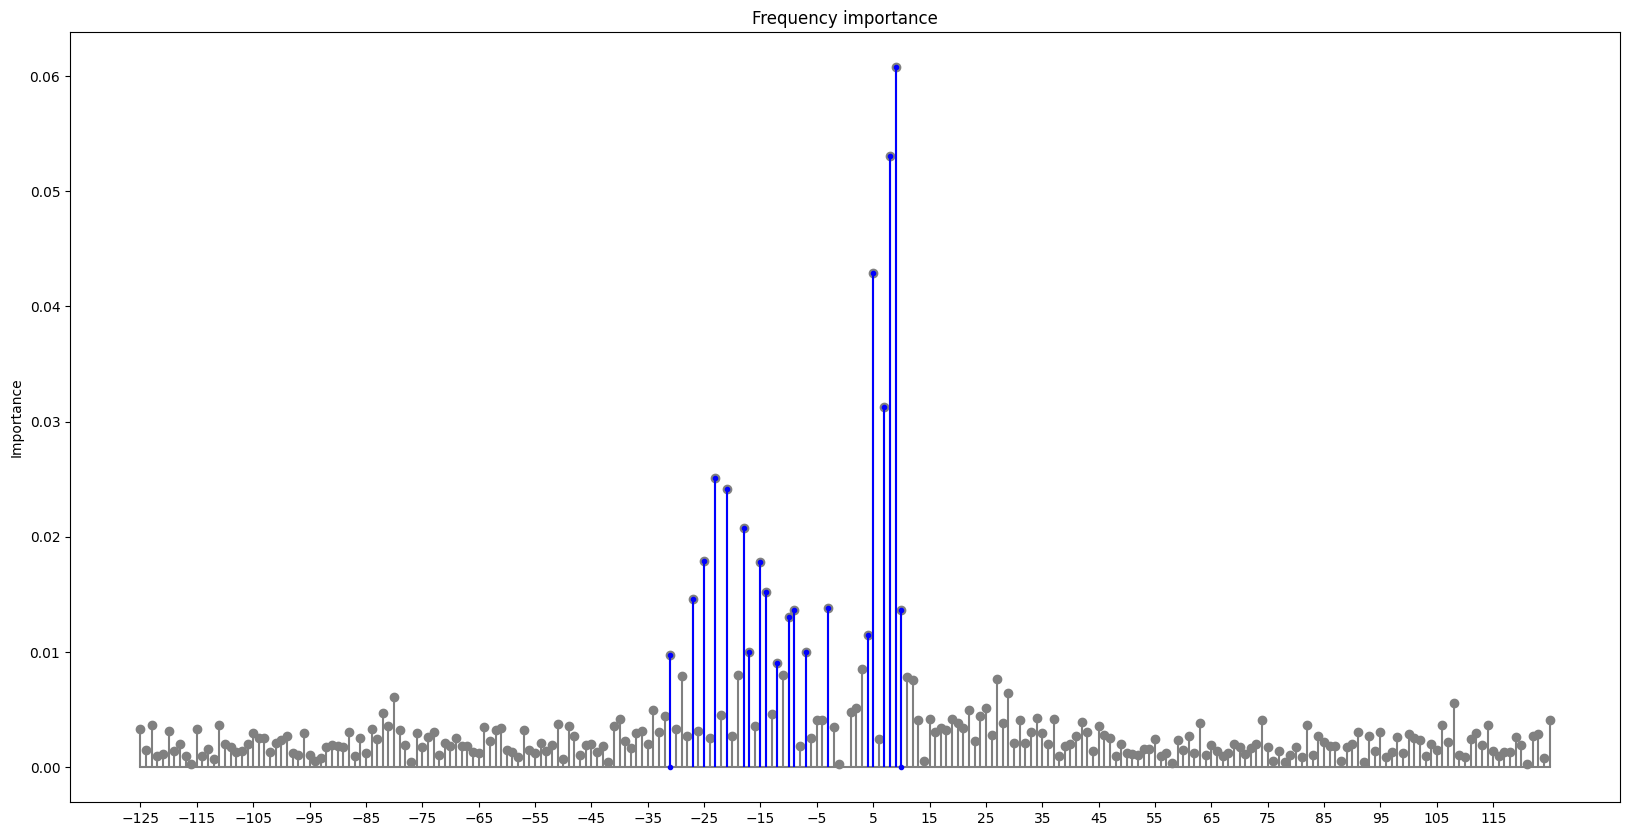

Frequency: -12, Importance: 0.009055839997831005
Frequency: -31, Importance: 0.009754634380368997
Frequency: -17, Importance: 0.010000337266063421
Frequency: -7, Importance: 0.01001766310121322
Frequency: 4, Importance: 0.011496380078619715
Frequency: -10, Importance: 0.013043706877614324
Frequency: 10, Importance: 0.013679781802331441
Frequency: -9, Importance: 0.01369469867804128
Frequency: -3, Importance: 0.013834530025377788
Frequency: -27, Importance: 0.01458761916569117
Frequency: -14, Importance: 0.015242735318878051
Frequency: -15, Importance: 0.01782179688244106
Frequency: -25, Importance: 0.017932031495200812
Frequency: -18, Importance: 0.020764894663465507
Frequency: -21, Importance: 0.02417848964052008
Frequency: -23, Importance: 0.025087551770176
Frequency: 7, Importance: 0.031263515685277944
Frequency: 5, Importance: 0.04287235726997981
Frequency: 8, Importance: 0.05304111809433135
Frequency: 9, Importance: 0.060760250515517394
random_forest
Confusion Matrix:
[[28  2]
 [ 

In [111]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

def classification_on_freqs(grp1, grp2, test_data, train_data, method='knn', min_max=False):
    combined = combine_groups(grp1, grp2, train_data)
    
    combined_test = combine_groups(grp1, grp2, test_data)

    # Keep only common chars for the test data aswell
    common_characters = common_chars(train_data[train_data[grp1] == True], train_data[train_data[grp2] == True])
    combined_test = combined_test[combined_test['Character'].isin(common_characters)]

    grp_column = combined[grp1]
    grp_column_test = combined_test[grp1]

    print(f'True means the font is {grp1}, otherwise it is {grp2} ')
    print("Training data shape:", combined.shape)
    print("Test data shape:", combined_test.shape)
    
    #print(grp_column)
    
    # Convert font labels to numerical
    font_labels, fonts = pd.factorize(grp_column)
    #print(font_labels ,fonts)
    grp_column = pd.Series(font_labels, name='Font_Label')
    
    font_labels_test, _ = pd.factorize(grp_column_test)
    grp_column_test = pd.Series(font_labels_test, name='Font_Label')
    
    
    spectra = combined.loc[:, '-125':]
    spectra = apply_parse_complex(spectra)
    spectra = apply_abs(spectra)

    spectra_test = combined_test.loc[:, '-125':]
    spectra_test = apply_parse_complex(spectra_test)
    spectra_test = apply_abs(spectra_test)

    if min_max:
        spectra, spectra_test = apply_min_max(spectra, spectra_test)
    #print(f'SPECTRA_TEST: {spectra_test}\n')
    #print(f'SPECTRA_TRAIN: {spectra}\n')

    
    if method == 'knn':
        classifier = KNeighborsClassifier(n_neighbors=5)
    elif method == 'random_forest':
        classifier = RandomForestClassifier()
    elif method == 'mlp':
        classifier = MLPClassifier(max_iter=2000)

    classifier.fit(spectra, grp_column)
    if method == 'random_forest':
        importances = classifier.feature_importances_
        indices = np.argsort(importances)[-20:]
        frequencies = [int(col) for col in spectra.columns]

        fig, ax = plt.subplots(figsize=(20, 10))
        # Plot all importances in grey
        plt.stem(frequencies, importances, linefmt='grey', markerfmt='grey', basefmt='grey')
    
        # Highlight important frequencies
        plt.stem(np.array(frequencies)[indices], importances[indices], linefmt='blue', markerfmt='b.', basefmt='b.')
        
        plt.xticks(range(int(-NB_COEFF / 2), int(NB_COEFF / 2), 10))
        plt.ylabel('Importance')
        plt.title('Frequency importance')
        plt.show()
        for i in indices:
            print(f"Frequency: {int(spectra.columns[i])}, Importance: {importances[i]}")
    
    predictions = classifier.predict(spectra_test)
    #print(f'Actual font class (group): \n {np.array(grp_column_test)}')
    #print(f'Predicitions: \n {predictions}')
    print(method)
    
    print("Confusion Matrix:")
    print(confusion_matrix(grp_column_test, predictions))
    print(f"\nClassification Report using {method}:")
    print(classification_report(grp_column_test, predictions))

    

# Classification with 250 frequencies
test_data = pd.read_csv('TestSerifFontSpectra.csv')
classification_on_freqs('Serif', 'SansSerif', test_data, data)

print("\n\n\n")
classification_on_freqs('Serif', 'SansSerif', test_data, data, 'random_forest', min_max=False)

print("\n\n\n")
classification_on_freqs('Serif', 'SansSerif', test_data, data, 'mlp')

True means the font is Serif, otherwise it is SansSerif 
Training data shape: (350, 51)
Test data shape: (90, 47)
knn
Confusion Matrix:
[[28  2]
 [ 7 53]]

Classification Report using knn:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86        30
           1       0.96      0.88      0.92        60

    accuracy                           0.90        90
   macro avg       0.88      0.91      0.89        90
weighted avg       0.91      0.90      0.90        90

True means the font is Serif, otherwise it is SansSerif 
Training data shape: (350, 51)
Test data shape: (90, 47)


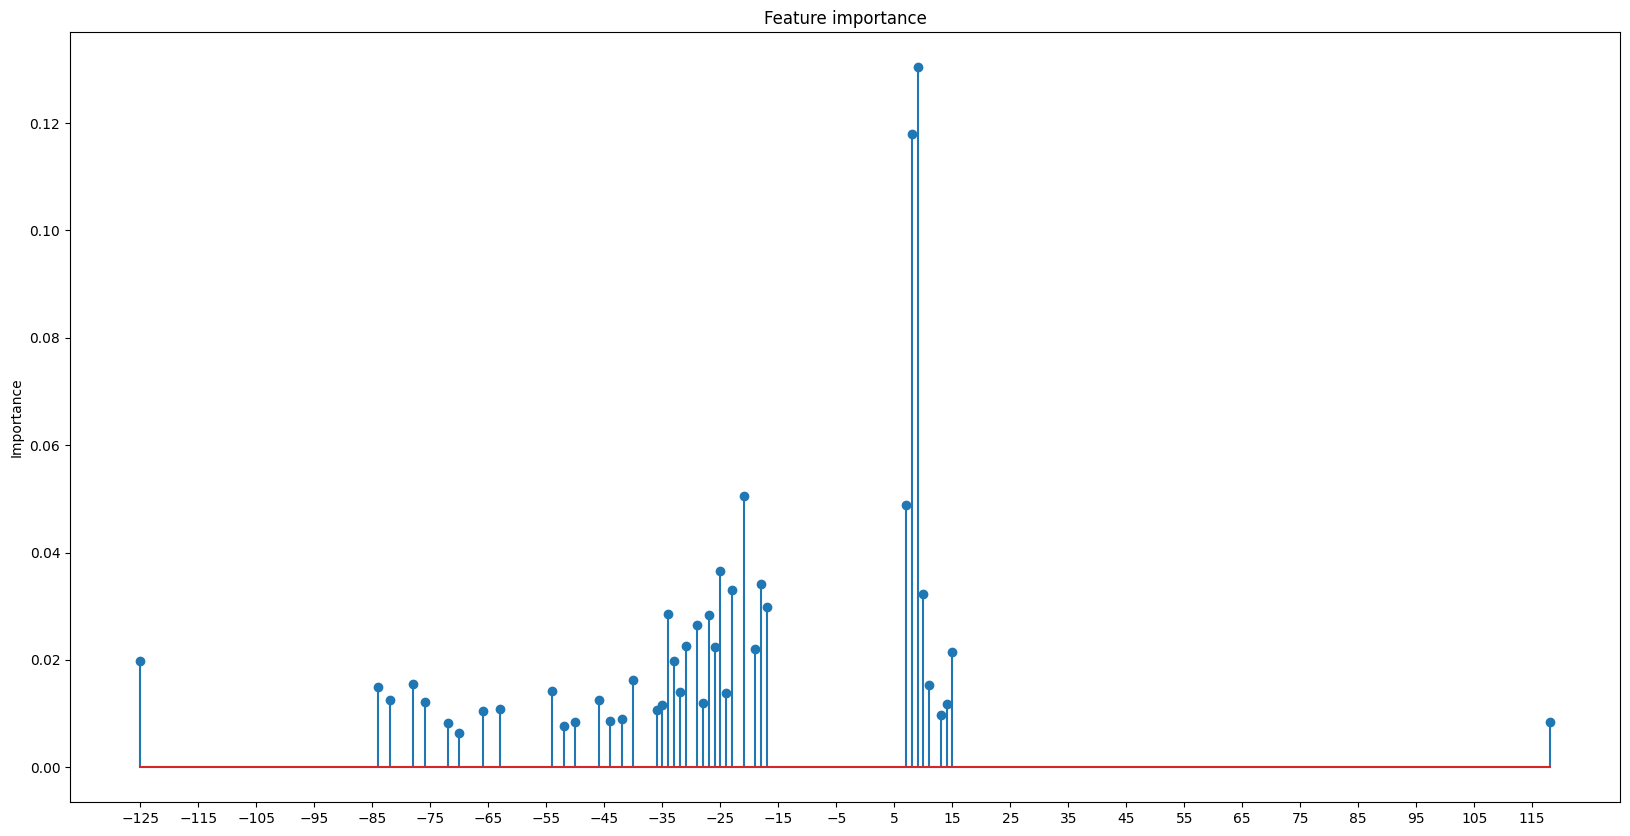

Frequency: -78, Importance: 0.015567958296424872
Frequency: -40, Importance: 0.016218446628427606
Frequency: -33, Importance: 0.019828092911201353
Frequency: -125, Importance: 0.019881619891715753
Frequency: 15, Importance: 0.021386631293976586
Frequency: -19, Importance: 0.02206652910791676
Frequency: -26, Importance: 0.02234519463895224
Frequency: -31, Importance: 0.022551765658489945
Frequency: -29, Importance: 0.0264405902185202
Frequency: -27, Importance: 0.02828676570945742
Frequency: -34, Importance: 0.028546243648681344
Frequency: -17, Importance: 0.029764501649559814
Frequency: 10, Importance: 0.03228458713144562
Frequency: -23, Importance: 0.03294232284742482
Frequency: -18, Importance: 0.03411103814803274
Frequency: -25, Importance: 0.03647867495697674
Frequency: 7, Importance: 0.04883021427975514
Frequency: -21, Importance: 0.05046894237261199
Frequency: 8, Importance: 0.11786036185578486
Frequency: 9, Importance: 0.1303681152790431
random_forest
Confusion Matrix:
[[29  1]


In [11]:
# Let's try KNN but without the low correlation frequencies
def filter_low_corr(corr_grp, data, threshold):
    # Remove category columns
    spectra = data.loc[:, '-125':]
    spectra = apply_parse_complex(spectra)
    spectra = apply_abs(spectra)
    correlation = pd.concat([spectra, data[corr_grp]], axis=1).corr()[corr_grp]

    # Filter frequencies (features) based on the correlation threshold
    selected_features = correlation[abs(correlation) >= threshold].index
    return selected_features.drop(corr_grp)



features = filter_low_corr('Serif', data, 0.15)
test_data = pd.read_csv('TestSerifFontSpectra.csv')

filtered = pd.concat([data.loc[:,:'-125'] , data[features]], axis=1)
filtered_test = pd.concat([test_data.loc[:,:'-125'] , test_data[features]], axis=1)
classification_on_freqs('Serif', 'SansSerif', filtered_test, filtered)
# The results are slightly better when filtering out frequencies with a low correlation (accuracy 9.82 instead 0.74)

# Let's what happens with the other classifiers
classification_on_freqs('Serif', 'SansSerif', filtered_test, filtered, 'random_forest')

classification_on_freqs('Serif', 'SansSerif', filtered_test, filtered, 'mlp')
# MLP has slightly better results when keeping all frequencies, random forest has similar results (slightly better with all frequencies)


True means the font is PreBezier, otherwise it is PostBezier 
Training data shape: (184, 259)
Test data shape: (52, 255)
knn
Confusion Matrix:
[[ 7 13]
 [23  9]]

Classification Report using knn:
              precision    recall  f1-score   support

           0       0.23      0.35      0.28        20
           1       0.41      0.28      0.33        32

    accuracy                           0.31        52
   macro avg       0.32      0.32      0.31        52
weighted avg       0.34      0.31      0.31        52





True means the font is PreBezier, otherwise it is PostBezier 
Training data shape: (184, 259)
Test data shape: (52, 255)


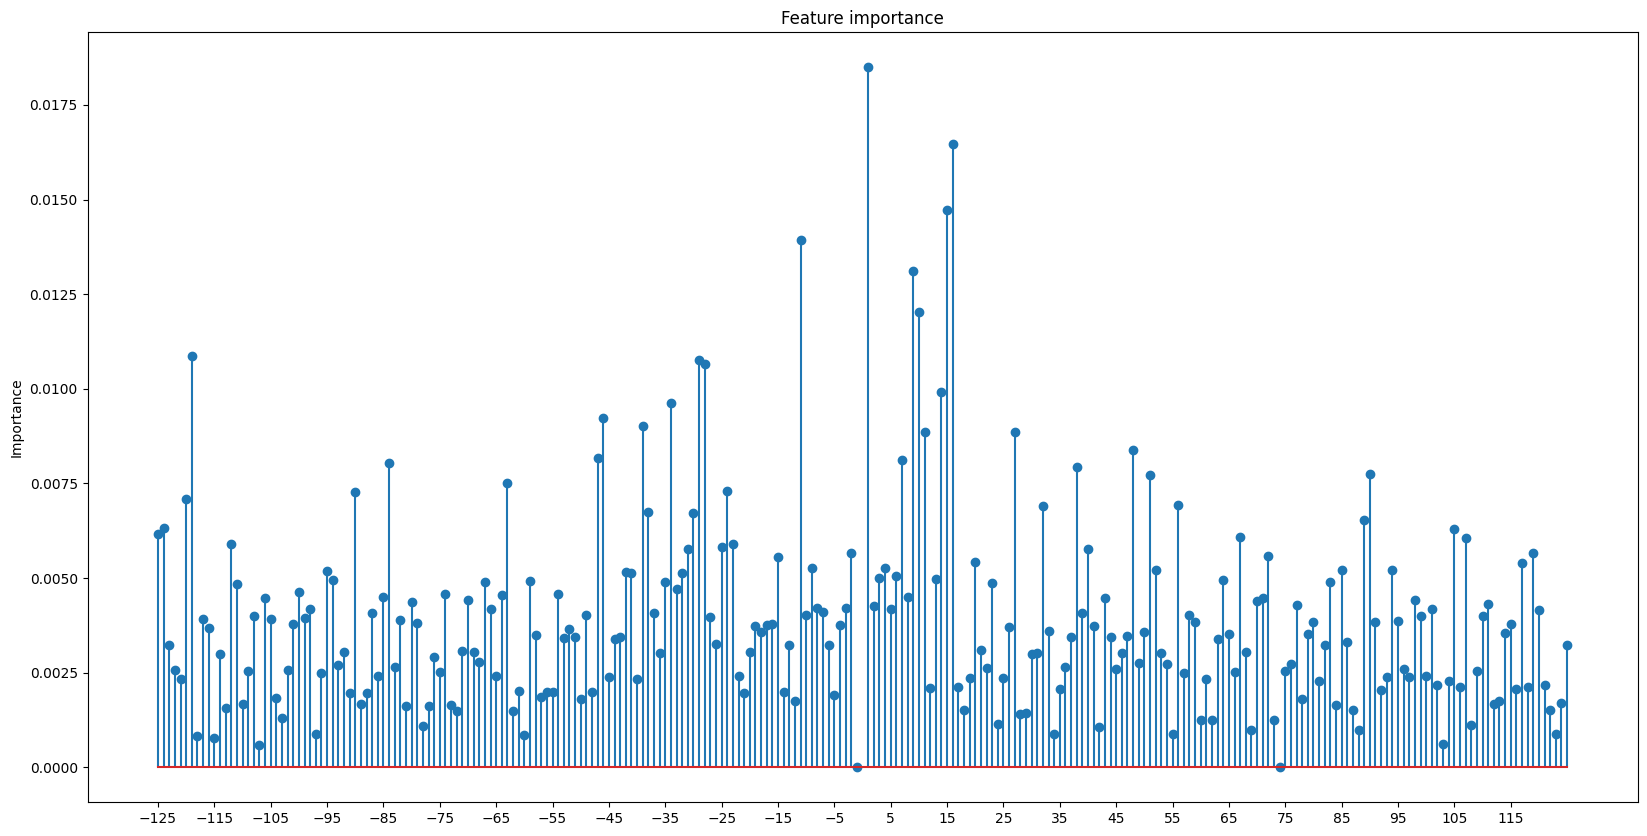

Frequency: 38, Importance: 0.007921958075710818
Frequency: -84, Importance: 0.008042866571820767
Frequency: 7, Importance: 0.008108851739749161
Frequency: -47, Importance: 0.008168624212415298
Frequency: 48, Importance: 0.008392688416284337
Frequency: 27, Importance: 0.008854125159779338
Frequency: 11, Importance: 0.008866713738559068
Frequency: -39, Importance: 0.009016324839815043
Frequency: -46, Importance: 0.009227642641301997
Frequency: -34, Importance: 0.00963388544157997
Frequency: 14, Importance: 0.009903560426093756
Frequency: -28, Importance: 0.010654105040341096
Frequency: -29, Importance: 0.010751555175930592
Frequency: -119, Importance: 0.010861324818236172
Frequency: 10, Importance: 0.012020438107985176
Frequency: 9, Importance: 0.01310671413169553
Frequency: -11, Importance: 0.013933075140966544
Frequency: 15, Importance: 0.014734056760809924
Frequency: 16, Importance: 0.016470386695333256
Frequency: 1, Importance: 0.01849419096202491
random_forest
Confusion Matrix:
[[14

/Users/isc/TB/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
# Let's test ou classification with other groups (with and without filtering frequencies)

# Classification with 250 frequencies
test_data = pd.read_csv('TestBezierFontSpectra.csv')
classification_on_freqs('PreBezier', 'PostBezier', test_data, data)

print("\n\n\n")
classification_on_freqs('PreBezier', 'PostBezier', test_data, data, 'random_forest')

print("\n\n\n")
classification_on_freqs('PreBezier', 'PostBezier', test_data, data, 'mlp')

# Trying to differentiate POST and PRE Bezier is not conclusive. Knn yields results even worse than randomly picking between the 2 classes.
# Anyway, the results are basically equivalent to random predictions (given this specific training set and test set).

# Maybe we should split the pre and post bezier font in serif/sans serif to see if within these two classes pre and post bezier can be differentiated.


True means the font is Serif, otherwise it is SansSerif 
Training data shape: (350, 259)
Test data shape: (90, 255)
Confusion Matrix:
[[22  8]
 [13 47]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.73      0.68        30
           1       0.85      0.78      0.82        60

    accuracy                           0.77        90
   macro avg       0.74      0.76      0.75        90
weighted avg       0.78      0.77      0.77        90






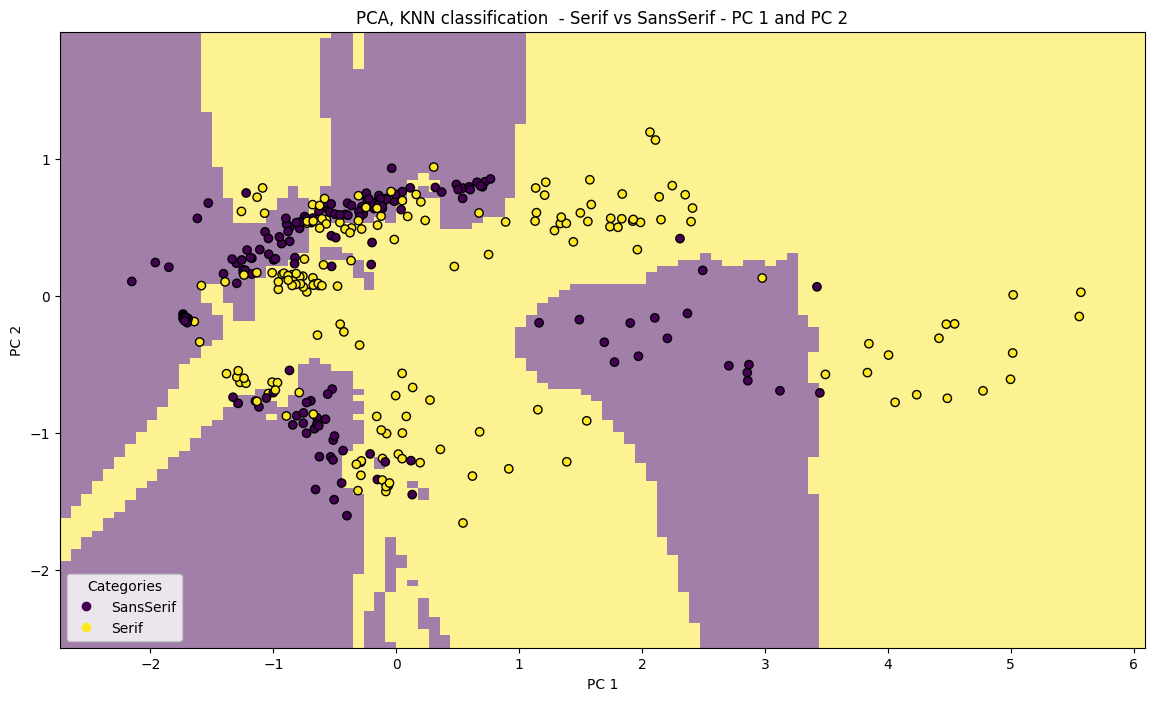

Confusion Matrix:
[[26  4]
 [25 35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.87      0.64        30
           1       0.90      0.58      0.71        60

    accuracy                           0.68        90
   macro avg       0.70      0.73      0.67        90
weighted avg       0.77      0.68      0.69        90






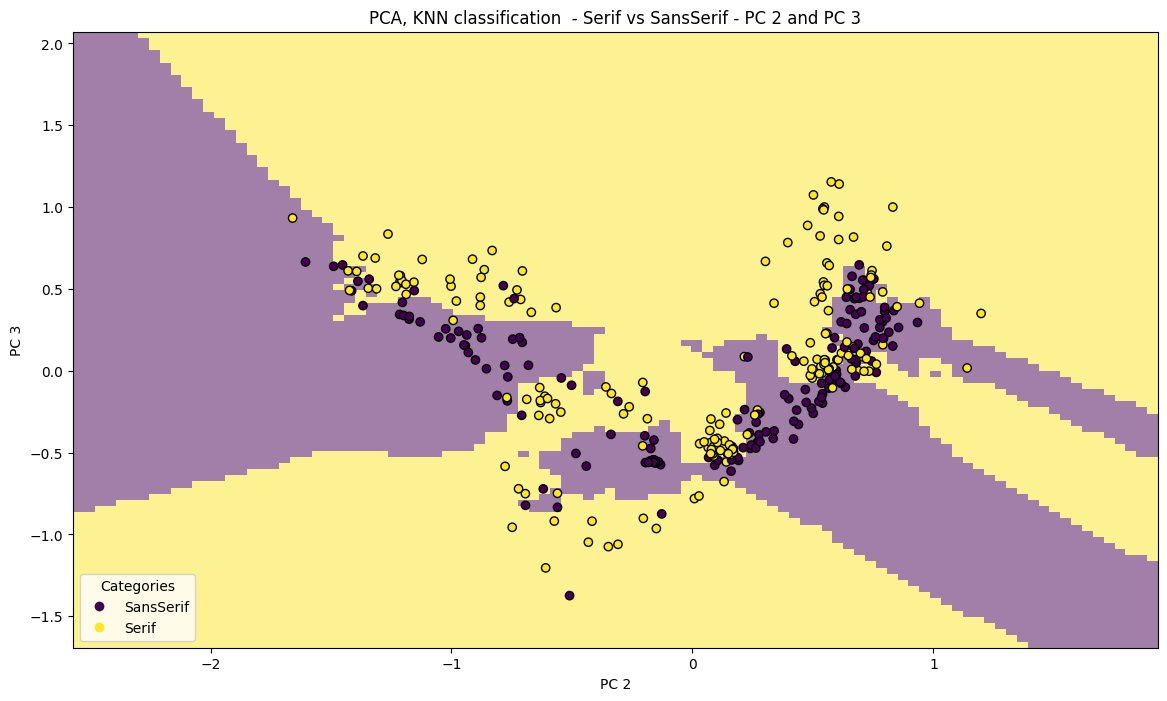

Confusion Matrix:
[[27  3]
 [16 44]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.90      0.74        30
           1       0.94      0.73      0.82        60

    accuracy                           0.79        90
   macro avg       0.78      0.82      0.78        90
weighted avg       0.83      0.79      0.79        90






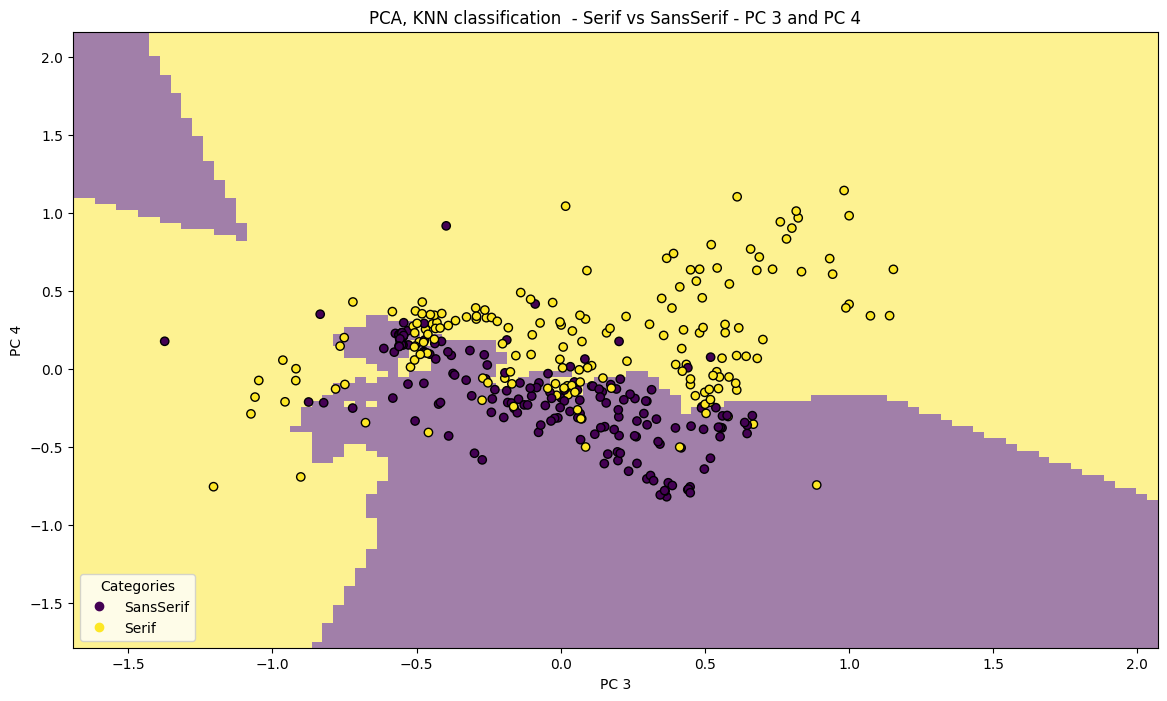

Confusion Matrix:
[[24  6]
 [13 47]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.80      0.72        30
           1       0.89      0.78      0.83        60

    accuracy                           0.79        90
   macro avg       0.77      0.79      0.77        90
weighted avg       0.81      0.79      0.79        90






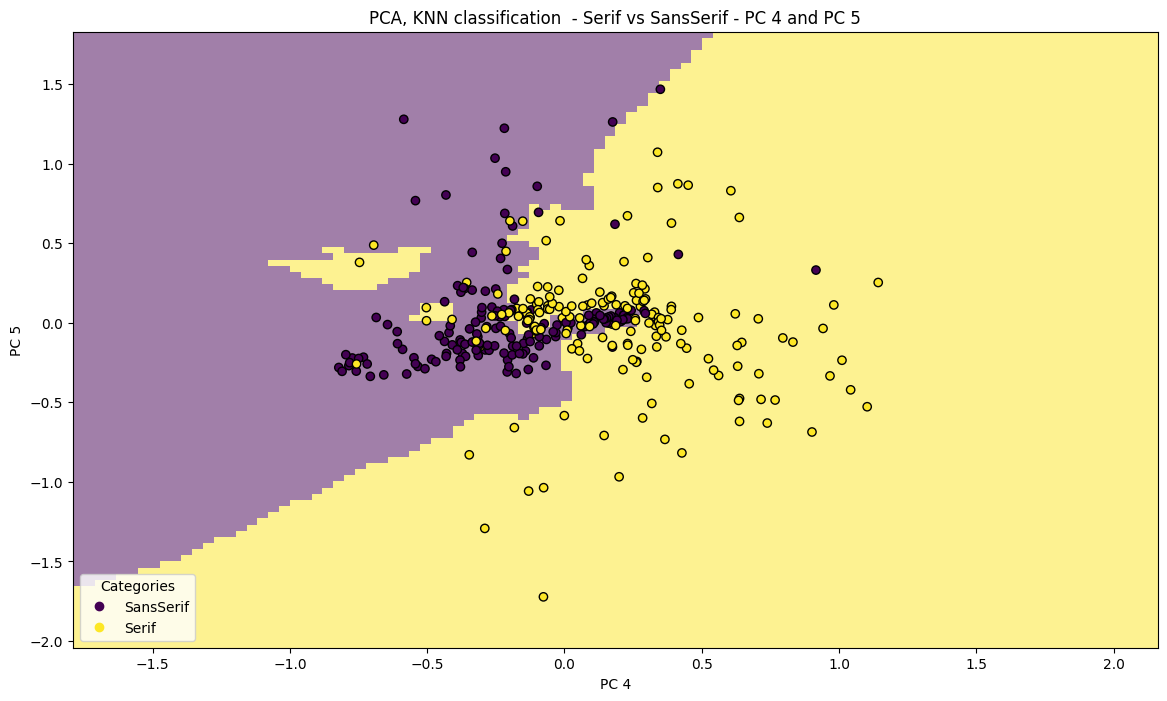

Confusion Matrix:
[[23  7]
 [19 41]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.77      0.64        30
           1       0.85      0.68      0.76        60

    accuracy                           0.71        90
   macro avg       0.70      0.73      0.70        90
weighted avg       0.75      0.71      0.72        90






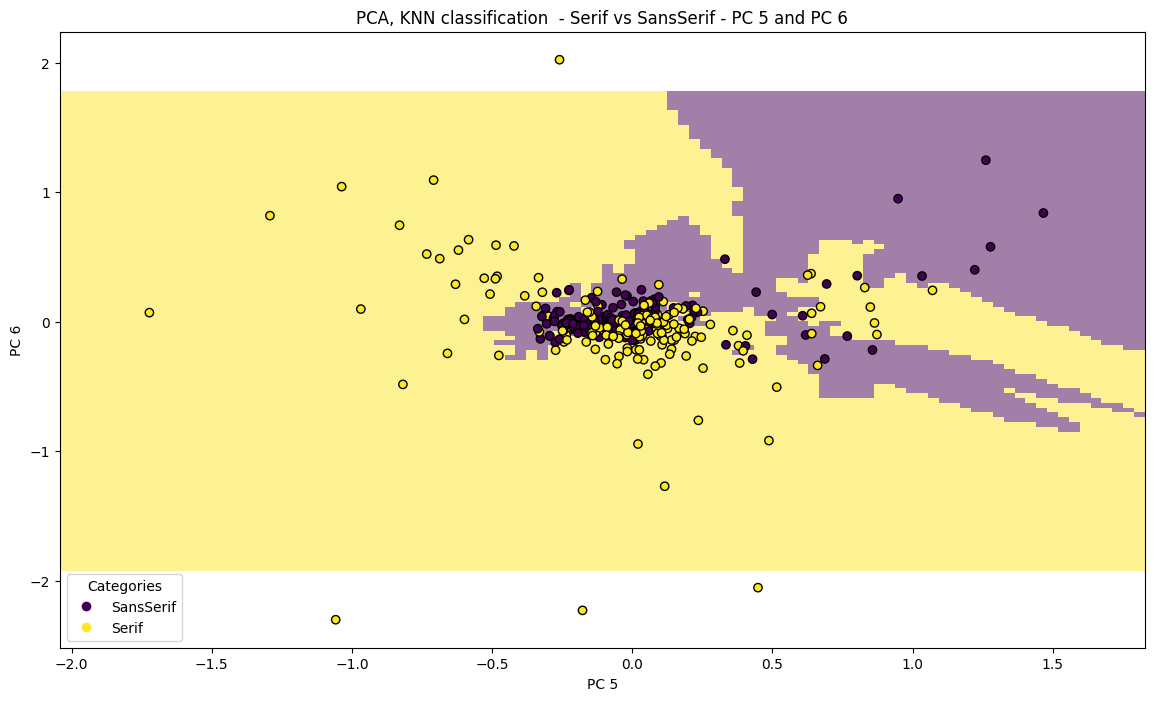

Confusion Matrix:
[[23  7]
 [23 37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.77      0.61        30
           1       0.84      0.62      0.71        60

    accuracy                           0.67        90
   macro avg       0.67      0.69      0.66        90
weighted avg       0.73      0.67      0.68        90






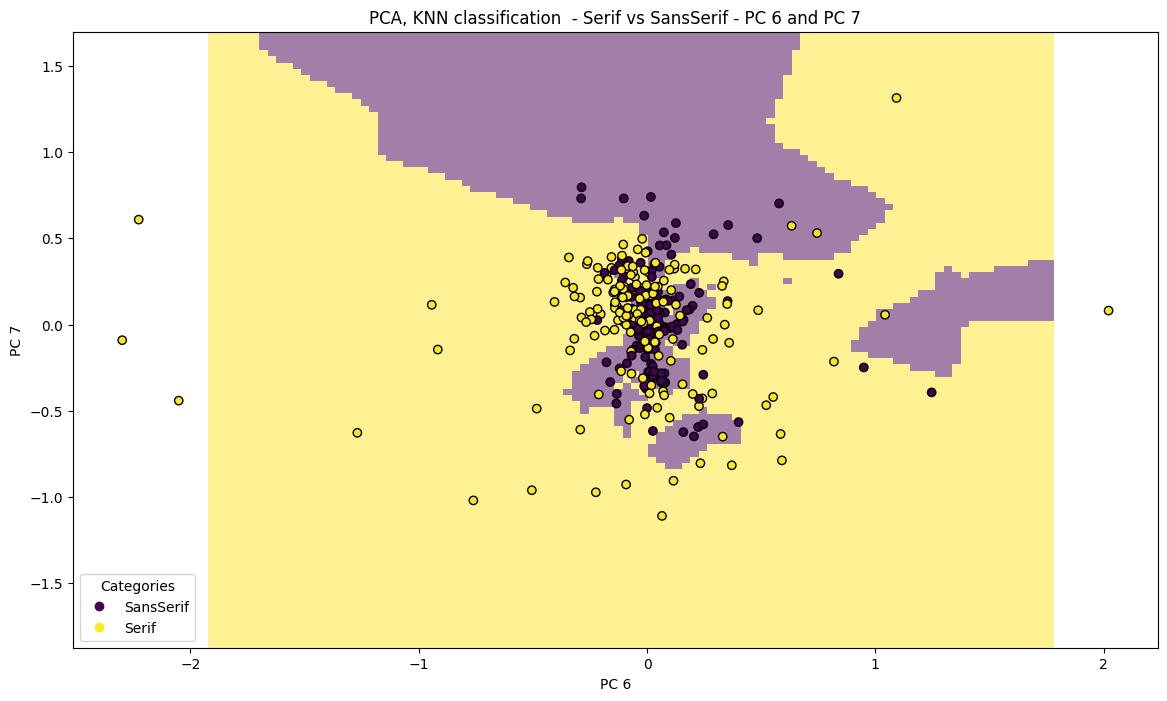

Confusion Matrix:
[[18 12]
 [29 31]]

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.60      0.47        30
           1       0.72      0.52      0.60        60

    accuracy                           0.54        90
   macro avg       0.55      0.56      0.53        90
weighted avg       0.61      0.54      0.56        90






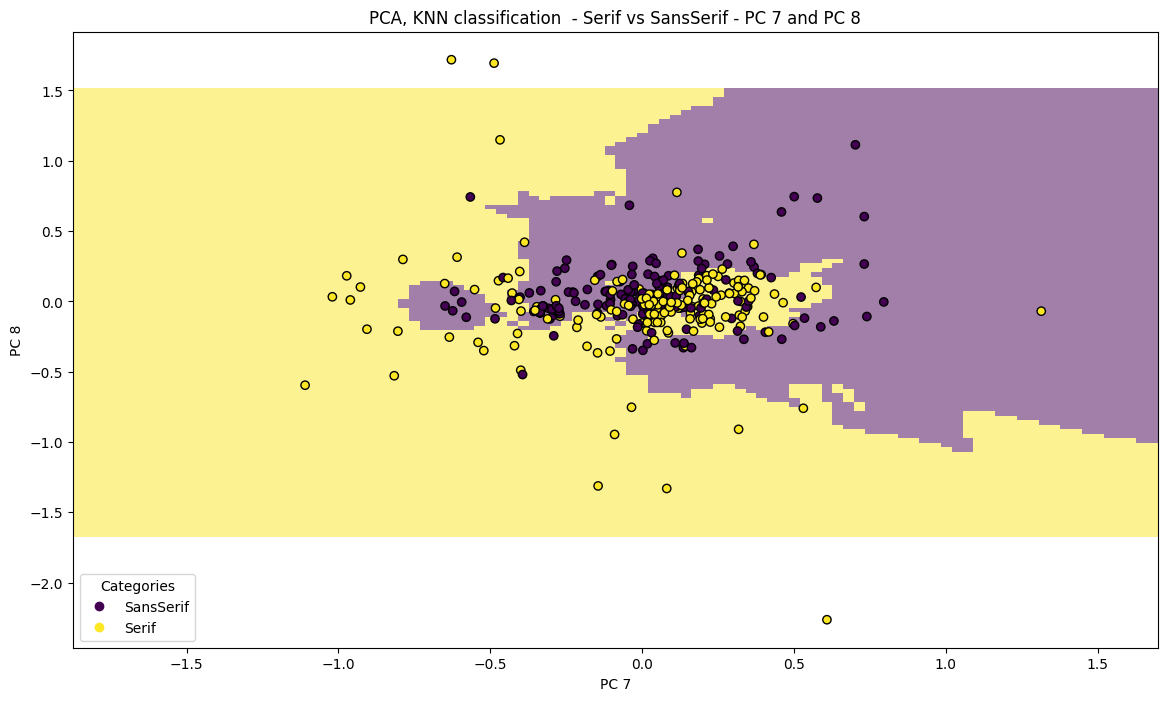

In [109]:
# Let's try KNN but using PCA beforehand
# KNN with 250 frequencies
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay

def group_knn_with_pca(grp1, grp2, test_data, min_max=False):
    combined = combine_groups(grp1, grp2, data)
    
    combined_test = combine_groups(grp1, grp2, test_data, common_chars_only=False)

    # Keep only common chars for the test data aswell
    common_characters = common_chars(data[data[grp1] == True], data[data[grp2] == True])
    combined_test = combined_test[combined_test['Character'].isin(common_characters)]

    grp_column = combined[grp1]
    grp_column_test = combined_test[grp1]

    print(f'True means the font is {grp1}, otherwise it is {grp2} ')
    print("Training data shape:", combined.shape)
    print("Test data shape:", combined_test.shape)


    
    #print(grp_column)
    # Convert font labels to numerical
    font_labels, fonts = pd.factorize(grp_column)
    #print(font_labels ,fonts)
    grp_column = pd.Series(font_labels, name='Font_Label')
    
    font_labels_test, _ = pd.factorize(grp_column_test)
    grp_column_test = pd.Series(font_labels_test, name='Font_Label')
    

    spectra = combined.loc[:, '-125':]
    spectra = apply_parse_complex(spectra)
    spectra = apply_abs(spectra)
    
    spectra_test = combined_test.loc[:, '-125':]
    spectra_test = apply_parse_complex(spectra_test)
    spectra_test = apply_abs(spectra_test)

    if min_max:
        spectra, spectra_test = apply_min_max(spectra, spectra_test)
    

    # compute PCA from train data, then transform the test data using the found PC.
    # ( I could alsop compute PCA with all the data (train + test) but only use train for KNN
    # combine train + test, then separate and add labels for the train data only)
    # I guess computing PCA from only the train data makes more sense though, doesn't it?
    
    pca = PCA(n_components=8)
    principalComponents = pca.fit_transform(spectra)
    components_Df = pd.DataFrame(data=principalComponents, columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8'])
    components_Df['Font_Label'] = grp_column.values

    # Transform the test data using computed PCA
    test_components = pca.transform(spectra_test)
    test_components_Df = pd.DataFrame(data=test_components, columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8'])

    #print(f'Actual font class (group): \n {np.array(grp_column_test)}')

    
    # Try KNN for different PC combinations
    for i in range(len(components_Df.columns) - 2):
        column1 = components_Df.columns[i]
        column2 = components_Df.columns[i+1]

        pc_values = pd.concat([components_Df.loc[:, column1], components_Df.loc[:, column2]], axis=1)
        test_pc_values = pd.concat([test_components_Df.loc[:, column1], test_components_Df.loc[:, column2]], axis=1)
        
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(pc_values, grp_column)
    
        predictions = knn.predict(test_pc_values)
        #print(f'Predicitions using {column1} and {column2}: \n {predictions}')
        
        print("Confusion Matrix:")
        print(confusion_matrix(grp_column_test, predictions))
        print("\nClassification Report:")
        print(classification_report(grp_column_test, predictions))
        print("\n\n")

        
        fig, ax = plt.subplots(figsize=(14, 8))
        disp = DecisionBoundaryDisplay.from_estimator(
            knn,
            test_pc_values,
            response_method="predict",
            plot_method="pcolormesh",
            xlabel=column1,
            ylabel=column2,
            shading="auto",
            alpha=0.5,
            ax=ax,
        )
        scatter = disp.ax_.scatter(pc_values.iloc[:, 0], pc_values.iloc[:, 1], c=grp_column.values, edgecolors="k")
        disp.ax_.legend(
            scatter.legend_elements()[0],
            [grp2, grp1],
            loc="lower left",
            title="Categories",
        )
        _ = disp.ax_.set_title(
            f"PCA, KNN classification  - {grp1} vs {grp2} - {column1} and {column2}"
        )

        plt.show()

    


test_data = pd.read_csv('TestSerifFontSpectra.csv')
#group_knn_all_freqs('Serif', 'SansSerif', test_data)
group_knn_with_pca('Serif', 'SansSerif', test_data, min_max=True)


In [14]:
# Let's try the classifiers but using 8 principal components from PCA 

def classification_on_pca(grp1, grp2, test_data, train_data, method='random_forest', min_max=False):
    combined = combine_groups(grp1, grp2, train_data)
    
    combined_test = combine_groups(grp1, grp2, test_data, common_chars_only=False)
    common_characters = common_chars(train_data[train_data[grp1] == True], train_data[train_data[grp2] == True])
    combined_test = combined_test[combined_test['Character'].isin(common_characters)]

    grp_column = combined[grp1]
    grp_column_test = combined_test[grp1]

    print(f'True means the font is {grp1}, otherwise it is {grp2} ')
    print("Training data shape:", combined.shape)
    print("Test data shape:", combined_test.shape)
    
    #print(grp_column)
    
    # Convert font labels to numerical
    font_labels, fonts = pd.factorize(grp_column)
    #print(font_labels ,fonts)
    grp_column = pd.Series(font_labels, name='Font_Label')

    # Check the train set is balanced
    print(grp_column.value_counts())
    
    font_labels_test, _ = pd.factorize(grp_column_test)
    grp_column_test = pd.Series(font_labels_test, name='Font_Label')
    
    
    spectra = combined.loc[:, '-125':]
    spectra = apply_parse_complex(spectra)
    spectra = apply_abs(spectra)

    
    spectra_test = combined_test.loc[:, '-125':]
    spectra_test = apply_parse_complex(spectra_test)
    spectra_test = apply_abs(spectra_test)

    if min_max:
        spectra, spectra_test = apply_min_max(spectra, spectra_test)
    
    #print(f'SPECTRA_TEST: {spectra_test}\n')
    #print(f'SPECTRA_TRAIN: {spectra}\n')


    pca = PCA(n_components=8)
    principalComponents = pca.fit_transform(spectra)
    components_Df = pd.DataFrame(data=principalComponents, columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8'])
    #components_Df['Font_Label'] = grp_column.values

    # Transform the test data using computed PCA
    test_components = pca.transform(spectra_test)
    test_components_Df = pd.DataFrame(data=test_components, columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8'])

    if method == 'random_forest':
        classifier = RandomForestClassifier()
    elif method == 'mlp':
        classifier = MLPClassifier(max_iter=2000)


    classifier.fit(components_Df, grp_column)
    predictions = classifier.predict(test_components_Df)
    print(f'Actual font class (group): \n {np.array(grp_column_test)}')
    print(f'Predicitions: \n {predictions}')
    print(method)
    
    print("Confusion Matrix:")
    print(confusion_matrix(grp_column_test, predictions))
    print(f"\nClassification Report using {method}:")
    print(classification_report(grp_column_test, predictions))

    

# Classification with 250 frequencies
test_data = pd.read_csv('TestSerifFontSpectra.csv')
classification_on_pca('Serif', 'SansSerif', test_data, data, 'random_forest')

print("\n\n\n")
classification_on_pca('Serif', 'SansSerif', test_data, data, 'mlp')

# Considering that the amplitudes of the lower frequencies are larger, when using PCA these frequencies impact the overall result
#(distributioon of points) way more that the higher frequencies. One way of alleviating this, is to normalize each column individually,
# having them contribute equally.

# Classification with 250 frequencies and normalizing each column
classification_on_pca('Serif', 'SansSerif', test_data, data, 'random_forest', min_max=True)

print("\n\n\n")
classification_on_pca('Serif', 'SansSerif', test_data, data, 'mlp', min_max=True)

True means the font is Serif, otherwise it is SansSerif 
Training data shape: (350, 259)
Test data shape: (90, 255)
Font_Label
0    180
1    170
Name: count, dtype: int64
Actual font class (group): 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predicitions: 
 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0]
random_forest
Confusion Matrix:
[[25  5]
 [ 8 52]]

Classification Report using random_forest:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79        30
           1       0.91      0.87      0.89        60

    accuracy                           0.86        90
   macro avg       0.83      0.85      0.84        90
weighted avg       0.86      0.86      0.86      

In [95]:

test_data = pd.read_csv('TestBezierSubGrps.csv')

#classification_on_pca('PreBezier', 'PostBezier', test_data, data, 'random_forest', min_max=True)

print("\n\n\n")
#classification_on_pca('PreBezier', 'PostBezier', test_data, data, 'mlp', min_max=True)


classification_on_pca('PreBezierSerif', 'PostBezierSerif', test_data, data_subgrps, 'random_forest', min_max=True)
print("\n\n\n")
classification_on_pca('PreBezierSerif', 'PostBezierSerif', test_data, data_subgrps, 'mlp', min_max=True)

#print("\n\n\n")
#classification_on_pca('PreBezierSans', 'PostBezierSans', test_data, data_subgrps, 'random_forest', min_max=True)
#print("\n\n\n")
#classification_on_pca('PreBezierSans', 'PostBezierSans', test_data, data_subgrps, 'mlp', min_max=True)





True means the font is PreBezierSerif, otherwise it is PostBezierSerif 
Training data shape: (290, 263)
Test data shape: (50, 257)
Font_Label
0    150
1    140
Name: count, dtype: int64
Actual font class (group): 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predicitions: 
 [1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1]
random_forest
Confusion Matrix:
[[10 10]
 [21  9]]

Classification Report using random_forest:
              precision    recall  f1-score   support

           0       0.32      0.50      0.39        20
           1       0.47      0.30      0.37        30

    accuracy                           0.38        50
   macro avg       0.40      0.40      0.38        50
weighted avg       0.41      0.38      0.38        50





True means the font is PreBezierSerif, otherwise it is PostBezierSerif 
Training data shape: (290, 263)
Test data shape: (50, 257)
Fo

/Users/isc/TB/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


## Conclusion on PRE POST Bezier fonts
We haven't been able to establish an actual difference between POST Bézier fonts and PRE Bézier fonts.
To partially answer if they if one group is more diverse than the other we can simply use the variance

-25    1.708303e-06
-24    2.218909e-06
-23    3.283917e-06
-22    2.399599e-06
-21    4.147032e-06
-20    4.258246e-06
-19    6.438099e-06
-18    8.597142e-06
-17    8.623633e-06
-16    1.402495e-05
-15    1.087244e-05
-14    2.479736e-05
-13    4.297642e-05
-12    1.090773e-04
-11    5.216799e-05
-10    1.285780e-04
-9     1.576590e-04
-8     4.739588e-04
-7     3.002300e-04
-6     3.586378e-04
-5     1.340049e-03
-4     9.097961e-03
-3     3.169765e-02
-2     4.109780e-02
-1     8.855538e-33
1      1.878403e-03
2      2.458129e-02
3      1.789718e-02
4      6.586169e-03
5      2.216151e-03
6      1.174448e-03
7      3.591312e-04
8      7.257657e-05
9      6.479332e-05
10     3.303884e-05
11     1.893661e-05
12     2.205244e-05
13     1.126447e-05
14     9.397870e-06
15     6.016383e-06
16     4.457296e-06
17     4.744128e-06
18     3.726364e-06
19     3.578658e-06
20     3.821457e-06
21     2.462278e-06
22     1.623133e-06
23     1.618795e-06
24     1.729619e-06
25     1.706850e-06


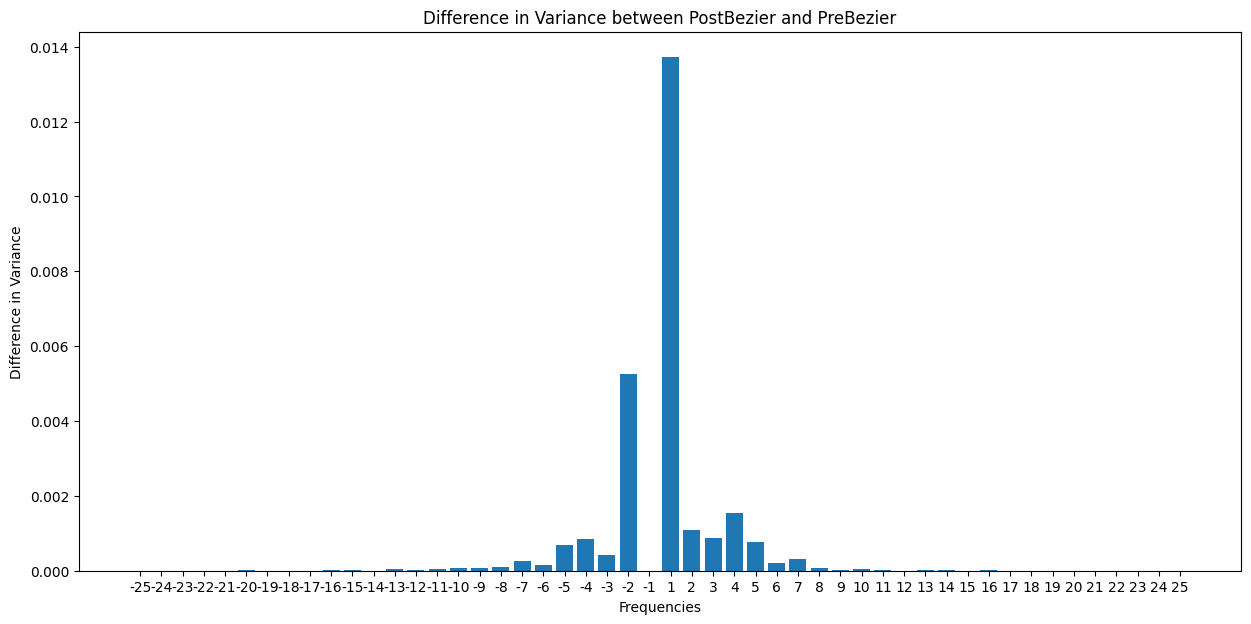

In [107]:
# Let's compute the variance for each group





spectra_post = combined[combined['PostBezier'] == True].loc[:, '-125':]
spectra_post = apply_parse_complex(spectra_post)
spectra_post = apply_abs(spectra_post)
spectra_post_low = spectra_post.loc[:, '-25':'25']

spectra_pre = combined[combined['PreBezier'] == True].loc[:, '-125':]
spectra_pre = apply_parse_complex(spectra_pre)
spectra_pre = apply_abs(spectra_pre)
spectra_pre_low = spectra_pre.loc[:, '-25':'25']

variance_post = spectra_post_low.var()
variance_pre = spectra_pre_low.var()

variance_difference = variance_post - variance_pre
variance_diff_abs = np.abs(variance_difference)

print(variance_post)

plt.figure(figsize=(15, 7))
plt.bar(variance_difference.index, variance_diff_abs.values)
plt.xlabel('Frequencies')
plt.ylabel('Difference in Variance')
plt.title('Difference in Variance between PostBezier and PreBezier')
num_ticks = 20
step = len(variance_difference) // num_ticks
ticks = np.arange(0, len(variance_difference), step)


Training data shape: (1451, 259)
Test data shape: (171, 255)
knn
Confusion Matrix:

Classification Report using knn:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         9
           6       1.00      0.89      0.94         9
           7       1.00      1.00      1.00         9
           8       0.90      1.00      0.95         9
           9       0.82      1.00      0.90         9
          10       0.90      1.00      0.95         9
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00         9
          14       1.00      1.00      1.00         9
          15      

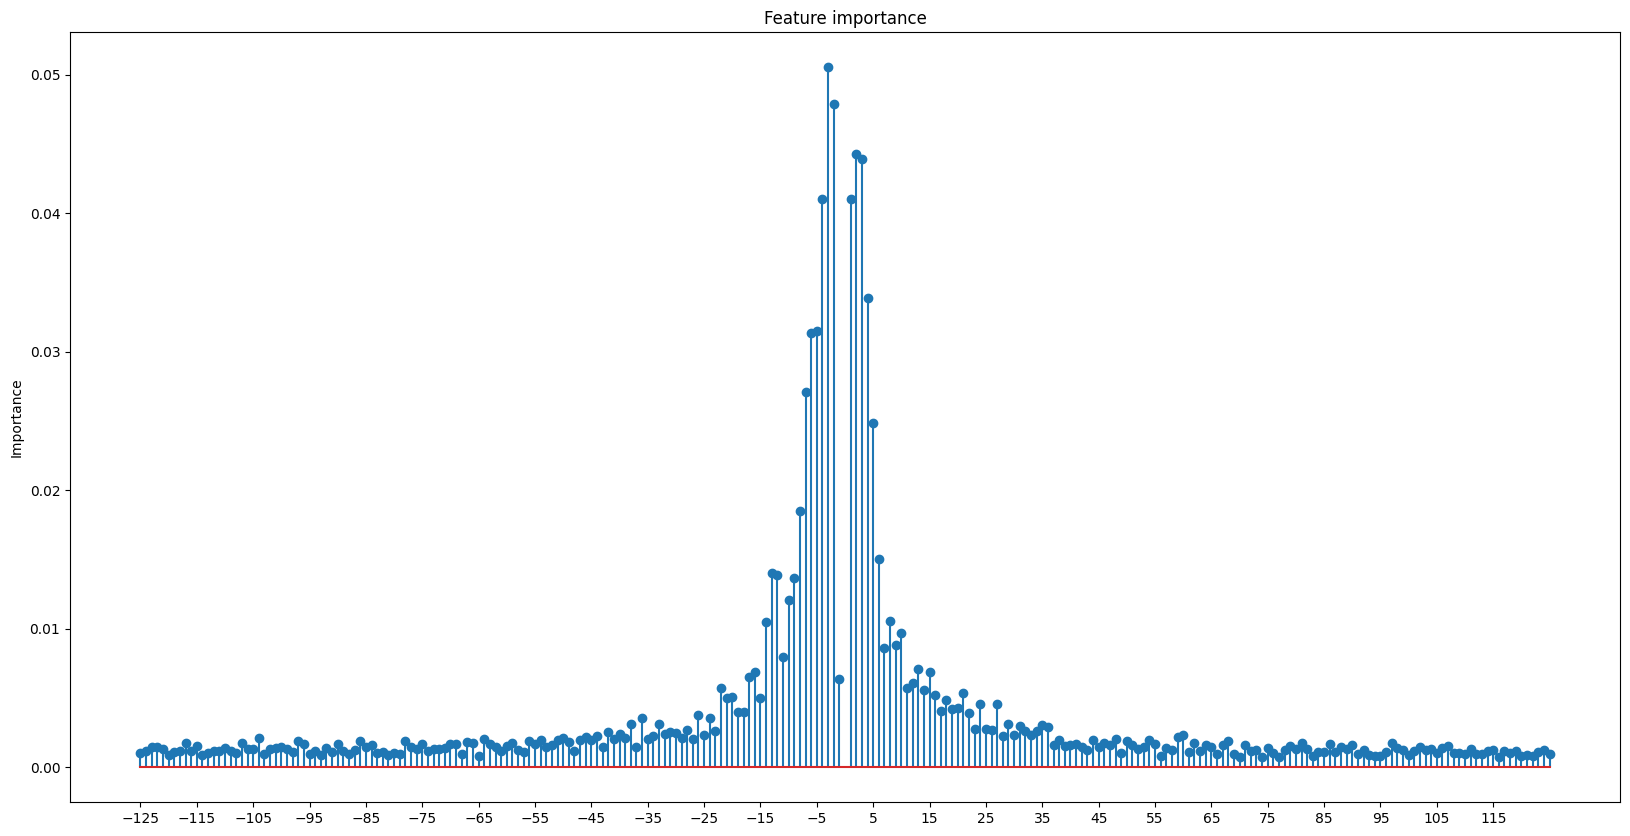

Frequency: 10, Importance: 0.009705409480788994
Frequency: -14, Importance: 0.010508735586236032
Frequency: 8, Importance: 0.010582990350400114
Frequency: -10, Importance: 0.012113745964746086
Frequency: -9, Importance: 0.013634440032281704
Frequency: -12, Importance: 0.013874586066664082
Frequency: -13, Importance: 0.014026208960733052
Frequency: 6, Importance: 0.015009007993003276
Frequency: -8, Importance: 0.01848607269281909
Frequency: 5, Importance: 0.024824660630702385
Frequency: -7, Importance: 0.027102117964406973
Frequency: -6, Importance: 0.03134905417361009
Frequency: -5, Importance: 0.031477426315505215
Frequency: 4, Importance: 0.033848602278514855
Frequency: 1, Importance: 0.04103185849913246
Frequency: -4, Importance: 0.0410481499170428
Frequency: 3, Importance: 0.04395122404689416
Frequency: 2, Importance: 0.044315683438875576
Frequency: -2, Importance: 0.0478870373027083
Frequency: -3, Importance: 0.05054209512883866
random_forest
Confusion Matrix:

Classification Repo

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

def char_classification_on_freqs(test_data, train_data, method='knn', min_max=False):

    char_column = train_data['Character']
    frequency = char_column.value_counts()
    
    # Only keep letters that appear at least ten times (otherwise they are irrelevant)
    train_data = train_data[train_data['Character'].isin(frequency[frequency >= 10].index)]
    train_data = train_data[train_data['Character'].str.isupper()]
    train_data = train_data[train_data['ControlGroup'] == False]

    frequency_test = test_data['Character'].value_counts()
    test_data = test_data[test_data['Character'].isin(frequency_test[frequency_test >= 5].index)]
    test_data = test_data[test_data['Character'].str.isupper()]
    
    char_column = train_data['Character']
    char_column_test = test_data['Character']

    print("Training data shape:", train_data.shape)
    print("Test data shape:", test_data.shape)
    
    char_labels, chars = pd.factorize(char_column)
    #print(char_column.value_counts())
    #print(char_column_test.value_counts())
    char_column = pd.Series(char_labels, name='Char_Label')
    
    char_labels_test, r = pd.factorize(char_column_test)
    char_column_test = pd.Series(char_labels_test, name='Char_Label')
    
    spectra = train_data.loc[:, '-125':]
    spectra = apply_parse_complex(spectra)
    spectra = apply_abs(spectra)

    spectra_test = test_data.loc[:, '-125':]
    spectra_test = apply_parse_complex(spectra_test)
    spectra_test = apply_abs(spectra_test)

    if min_max:
        spectra, spectra_test = apply_min_max(spectra, spectra_test)
    
    if method == 'knn':
        classifier = KNeighborsClassifier(n_neighbors=5)
    elif method == 'random_forest':
        classifier = RandomForestClassifier()
    elif method == 'mlp':
        classifier = MLPClassifier(max_iter=2000)

    classifier.fit(spectra, char_column)
    if method == 'random_forest':
        importances = classifier.feature_importances_
        indices = np.argsort(importances)[-20:]
        frequencies = [int(col) for col in spectra.columns]

        fig, ax = plt.subplots(figsize=(20, 10))
        plt.stem(frequencies, importances)
        plt.xticks(range(int(-NB_COEFF / 2), int(NB_COEFF / 2), 10))
        plt.ylabel('Importance')
        plt.title('Feature importance')
        plt.show()
        for i in indices:
            print(f"Frequency: {int(spectra.columns[i])}, Importance: {importances[i]}")
    
    predictions = classifier.predict(spectra_test)
    #print(f'Actual font class (group): \n {np.array(grp_column_test)}')
    #print(f'Predicitions: \n {predictions}')
    print(method)
    
    print("Confusion Matrix:")
    #print(confusion_matrix(char_column_test, predictions))
    print(f"\nClassification Report using {method}:")
    print(classification_report(char_column_test, predictions))

    

# Classification with 250 frequencies
test_data = pd.read_csv('TestSerifFontSpectra.csv')
char_classification_on_freqs(test_data, data)

print("\n\n\n")
char_classification_on_freqs(test_data, data, 'random_forest', min_max=True)
print("\n\n\n")
char_classification_on_freqs(test_data, data, 'mlp', min_max=True)